<h1 align="center" style="color:#00008b"> 
    <b> MISE EN PLACE D'UN SYSTEME DE PREVISION DE PUISSANCE DES PANNEAUX PHOTOVOLTAIQUES SANS RECOURS AUX PLATEFORMES METEROLOGIQUES </b>
</h1>
<h3 align="center"> Prédiction de la Radiation par les méthodes naives, la moyenne et la médiane </h3>

<h1 align="center"> 
    <a href="https://github.com/ndohvich/" target="_blank"><b> NDOH NDOH Jules Moïse Yannick </b></a>
    <h4 align="center"> <b>ndohmoise@gmail.com | LABORATOIRE : Signaux Images et Systèmes | ENSET EBOLOWA | +237 695994053</b></h4> 
</h1>

In [2]:
%cd C:\Users\HP\m2r\finale\images

C:\Users\HP\m2r\finale\images


# <font color = '#00008b'>**I- Importation des bibliothèques nécessaires**<font/><a class = 'titre1' id = 'titre1'/>

In [4]:
#Elle me permet d'éffectuer les opérations mathématiques sur les tableaux
import numpy as np
#Elle me permet de manipuler les structures de données
import pandas as pd
#Elle me permet de visualiser les données à travers des figures
import matplotlib.pyplot as plt
#Elle me permet de visualiser les données à travers les figures optimisés
import seaborn as sns
#Me permet de faire la gestion des dates 
import datetime as dt
#Me permet d'importer la librairie datetime
#Me permet de faire des visuels 3D
import plotly.express as px
import plotly.graph_objects as go
#Me permet d'utiliser le modèle statistique 
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.signal import periodogram
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL
from datetime import datetime
#Me permet de gérer la racine carée d'un nombre
from math import sqrt
#Me permet de gérer la moyenne et la mediane 
from numpy import mean, median
from multiprocessing import cpu_count
from joblib import delayed, Parallel
from warnings import catch_warnings, filterwarnings 
from sklearn.metrics import mean_squared_error, r2_score
#Elle permet de renforcer le traitement des données avant utilisation
from sklearn.pipeline import Pipeline
#Me permet de tranformer les données dans le pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
#Elle me permet de faire une selection sur les variables
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.ensemble import IsolationForest

# <font color = '#00008b'>**II- Les Fonctions Utiles**<font/><a class = 'titre2' id = 'titre2'/>

In [6]:
#Cette fonction me  permet de Détecter les valeurs abérrantes par la méthode de l'écart-type 
def detect_outliers_std(df, columns, seuil=3):
    outliers_dict = {}
    for col in  columns:
        mean = df[col].mean()
        std_dev = df[col].std()
        outliers = (df[col] > mean + seuil * std_dev) | (df[col] < mean - seuil * std_dev)
        outliers_dict[col] = df[outliers]
    return outliers_dict

In [7]:
#Cette fonction me permet de Détecter les valeurs abérrantes par la méthode de l'intervalle interquartile
def detect_outliers_iqr(df, columns, k=1.5):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[col] < (Q1 - k * IQR)) | (df[col] > (Q3 + k * IQR))
        outliers_dict[col] = df[outliers]
    return outliers_dict

In [8]:
#Cette fonction me permet de rechercher les valeurs manquantes dans la base de données 
def missing_values_report(df):
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data /len(df))*100
    missing_report = pd.DataFrame({'Valeurs Manquantes': missing_data, 'Pourcentage': missing_percentage})
    return missing_report

In [9]:
#Définition d'une fonction qui affiche les différents pourcentages
def pourcentage(data):
    #Me permet de déterminer le nombre de ligne de la base de données
    n = data.shape[0]
    #me permet de rechercher les valeurs manquantes
    ret = pd.DataFrame(data.isnull().sum(), columns=['nbre_manq'])
    #permet de rechercher les doublons dans le tableau
    ret['doublons'] = data.duplicated(keep=False).sum()
    #Me permet de déterminer le mode de chaque variable
    #ret['mode'] = data.mode()
    #ret['mode'] = mode.transpose()
    #Me permet de déterminer la moyenne de chaque variable 
    ret['moyenne'] = data.mean()
    #Me permet de déterminer la mediane de chaque variable 
    ret['mediane'] = data.median()
    #Me permet de calculer la variance de chaque variable 
    ret['variance'] = round(data.var())
    #Me permet de calculer l'écart type de chaque variable
    ret['std'] = round(data.std())
    #Me permet de calculer le coef de variation
    ret['coef_var'] = (data.std())/(data.mean())
    #Me permet de calculer la mesure d'asymétrie Skewness
    ret['skewness'] = data.skew()
    #Me permet de calculer la mesure d'asymétrie kurtosis
    ret['kurtosis'] = data.kurt()
    #Me permet de calculer le max d'une variable 
    ret['max'] = data.max()
    #Me permet de calculer le min d'une variable 
    ret['min'] = data.min()
    return ret

In [10]:
# one-step simple forecast 
def simple_forecast(history, config): 
    n, offset, avg_type = config 
    # persist value, ignore other config 
    if avg_type == 'persist':
        return history[-n] 
    # collect values to average 
    values = list() 
    if offset == 1: 
        values = history[-n:] 
    else: 
        # skip bad configs 
        if n*offset > len(history): 
            raise Exception('Config beyond end of data : %d %d' % (n,offset)) 
        # try and collect n values using offset 
        for i in range(1, n+1): 
            ix = i * offset 
            values.append(history[-ix]) 
    # check if we can average
    if len(values) < 2: 
        raise Exception('Cannot calcultate average') 
    # mean of last n values 
    if avg_type == 'mean':
        return mean(values)
    # median of last n values 
    return median(values)

In [11]:
#Me permet de calculer rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [12]:
#Me permet de calculer r2
def measure_r2(actual, predicted):
    return r2_score(actual, predicted)

In [13]:
#Me permet de découper la bd en train/test
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [14]:
# walk-forward validation for univariate data 
def walk_forward_validation(data, n_test, cfg): 
    predictions = list() # split dataset 
    train, test = train_test_split(data, n_test) # seed history with training dataset 
    history = [x for x in train] # step over each time-step in the test set 
    for i in range(len(test)): # fit model and make forecast for history 
        yhat = simple_forecast(history, cfg) # store forecast in list of predictions 
        predictions.append(yhat) # add actual observation to history for the next loop 
        history.append(test[i]) # estimate prediction error 
    error = measure_rmse(test, predictions) 
    return error

In [15]:
# score a model, return None on failure 
def score_model(data, n_test, cfg, debug=False): 
    result = None # convert config to a key 
    key = str(cfg) # show all warnings and fail on exception if debugging 
    if debug: 
        result = walk_forward_validation(data, n_test, cfg) 
    else: # one failure during model validation suggests an unstable config 
        try: # never show warnings when grid searching, too noisy 
            with catch_warnings(): 
                filterwarnings("ignore") 
                result = walk_forward_validation(data, n_test, cfg) 
        except: 
            error = None # check for an interesting result 
    if result is not None: 
        print(' > Model[%s] %.3f' % (key, result)) 
    return (key, result)

In [16]:
# grid search configs 
def grid_search(data, cfg_list, n_test): 
    scores = None 
    #if parallel: # execute configs in parallel 
     #   executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
      #  tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
       # scores = executor(tasks) 
    #else: 
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list] # remove empty results 
    scores = [r for r in scores if r[1] != None] # sort configs by error, asc 
    scores.sort(key=lambda tup: tup[1])
    return scores

In [17]:
# create a set of simple configs to try 
def simple_configs(max_length, offsets=[1]): 
    configs = list() 
    for i in range(1, max_length+1): 
        for o in offsets: 
            for t in ['persist', 'mean', 'median']: 
                cfg = [i, o, t] 
                configs.append(cfg) 
    return configs

In [18]:
#Me permet de calculer le score
def make_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

In [19]:
#Me permet de tracer les courbes des différents scores
def plot_scores(scores: pd.Series, score_type: str):
    scores = scores.sort_values(ascending=False)  
    sns.barplot(x=scores, y=scores.index)

    if score_type == "mi":
        plt.xlabel("Mutual Information Scores")
    elif score_type == "corr":
        plt.xlabel("Correlation Scores")

    for i, score in enumerate(scores):
        plt.text(score + 0.05, i, f"{score:.2f}", ha="center")

    plt.grid(True)
    plt.savefig("mi_scores.jpg")

In [20]:
#Me permet de tracer le score des corrélations
def make_corr_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    X_numeric = X.select_dtypes(include=['number'])
    y_numeric = y.to_frame().select_dtypes(include=['number'])

    if y_numeric.empty:
        raise ValueError("La variable cible doit être numérique")

    corr_scores = X_numeric.corrwith(y_numeric.iloc[:,0])
    corr_scores = pd.Series(corr_scores, name="Correlation Scores", index=X.columns)
    corr_scores = corr_scores.abs().sort_values(ascending=False)
    return corr_scores

In [21]:
#Me permet d'afficher le graphe des corrélations
def correlation_graph(pca, x_y, features) :
    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 8))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Nom de la figure
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et affichage
    plt.axis('equal')
    plt.savefig("x_y.jpg")
    plt.show(block=False)

In [22]:
#Me permet d'afficher le graphe des corrélations
def correlation_graph(pca, x_y, features) :
    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 8))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Nom de la figure
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et affichage
    plt.axis('equal')
    plt.grid(True)
    plt.savefig("cercle_de_corrélation.jpg")
    plt.show(block=False)

In [23]:
def display_factorial_planes(X_projected, x_y, pca=None, labels = None, clusters=None, alpha=1, figsize=[10,8], marker="o" ):
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)
    
    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')

    # Titre et Affichage
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

In [24]:
def plot_time_series(time, values, label, legends=None):
    if legends is not None:
        assert len(legends)==len(values)
    if isinstance(values, list):
        series_dict = {"Time": time}
        for v, l in zip(values, legends):
            series_dict[l] = v
        plot_df = pd.DataFrame(series_dict)
        plot_df = pd.melt(plot_df,id_vars="Time",var_name="ts", value_name="Value")
    else:
        series_dict = {"Time": time, "Value": values, "ts":""}
        plot_df = pd.DataFrame(series_dict)
    
    if isinstance(values, list):
        fig = px.line(plot_df, x="Time", y="Value", line_dash="ts")
    else:
        fig = px.line(plot_df, x="Time", y="Value")
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title={
        'text': label,
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        titlefont={
            "size": 25
        },
        yaxis=dict(
            title_text="Value",
            titlefont=dict(size=12),
        ),
        xaxis=dict(
            title_text="Time",
            titlefont=dict(size=12),
        )
    )
    return fig
    
def generate_timeseries(signal, noise=None):
    time_sampler = ts.TimeSampler(stop_time=20)
    regular_time_samples = time_sampler.sample_regular_time(num_points=100)
    timeseries = ts.TimeSeries(signal_generator=signal, noise_generator=noise)
    samples, signals, errors = timeseries.sample(regular_time_samples)
    return samples, regular_time_samples, signals, errors

In [25]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", figsize=(500,900), font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=figsize[1],
            height=figsize[0],
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [26]:
def decomposition_plot(
        ts_index, observed=None, seasonal=None, trend=None, resid=None
    ):
        """Plots the decomposition output
        """
        series = []
        if observed is not None:
            series += ["Original"]
        if trend is not None:
            series += ["Trend"]
        if seasonal is not None:
            series += ["Seasonal"]
        if resid is not None:
            series += ["Residual"]
        if len(series) == 0:
            raise ValueError(
                "All component flags were off. Need atleast one of the flags turned on to plot."
            )
        fig = make_subplots(
            rows=len(series), cols=1, shared_xaxes=True, subplot_titles=series
        )
        x = ts_index
        row = 1
        if observed is not None:
            fig.append_trace(
                go.Scatter(x=x, y=observed, name="Original"), row=row, col=1
            )
            row += 1
        if trend is not None:
            fig.append_trace(
                go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1
            )
            row += 1
        if seasonal is not None:
            fig.append_trace(
                go.Scatter(x=x, y=seasonal, name="Seasonal"),
                row=row,
                col=1,
            )
            row += 1
        if resid is not None:
            fig.append_trace(
                go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1
            )
            row += 1

        fig.update_layout(
            title_text="Seasonal Decomposition",
            autosize=False,
            width=1200,
            height=1000,
            title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
            titlefont={"size": 20},
            legend_title=None,
            showlegend=False,
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
        return fig

In [27]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    ax.grid(True)
    return ax

In [28]:
#Me permet de fair la division de ma variable cible en plusieurs variable cible antérieur
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    plt.grid(True)
    plt.savefig('plot_lags.jpg')

In [29]:
#Me permet de faire le test de stationarité et de voir la figure
def test_stationarity(timeseries):
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Moyenne Mobile')
    std = plt.plot(MSTD, color='black', label = 'Ecart-type Mobile')
    plt.legend(loc='best')
    plt.savefig('test_de_stationarité.jpg')
    plt.grid(True)
    plt.title('Moyenne Mobille et Ecart-Type')
    plt.show(block=False)

    print('Resultats du test de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Tests Statistiques','p-value','#Lags Utilisés','Nombre Observation utilisé'])
    for key,value in dftest[4].items():
        dfoutput['Valeur critique (%s)'%key] = value
    print(dfoutput)

In [30]:
#Me permet de faire le tracer de l'ACF et PACF
def tsplot(y, lags=None, figsize=(30, 15), style='bmh'):

    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (4, 4)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Graphique de l\' Analyse des séries temporelles\n Dickey-Fuller: p={0:.10f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.savefig('tsplot.jpg')

In [31]:
#Me permet de tracer le periodogramme de la variable cible 
def plot_periodogram(ts, detrend='linear', ax=None):
    
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annuel (1)",
            "Semestriel (2)",
            "Trimestriel (4)",
            "Bimensuel (6)",
            "Mensuel (12)",
            "Bimensuel (26)",
            "Hebdomadaire (52)",
            "Bihdomadaire (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogramme")
    ax.grid(True)
    return ax

In [32]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Visualisation Saisonnière ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )

    ax.grid(True)
    return ax

In [33]:
def eval_model(model):
    import time
    t_start =  time.perf_counter()
    print("Début: " + str(model))

    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == ns_model:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()

    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R2":res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("\n Fin: " + str(model) + ":" + str(res_time) + "sec \n\n")
    return results

In [34]:
#Elle permet de gérer les variables de gestion de temps
from time import time
#Me permet de faire les calculs sur les modèles de prédiction
def make_model(nom_model):
    #Me permet d'enregistrer le temps d'entrainement et prédiction
    start = time()
    #Me permet de faire la mise en place du modèle
    model = nom_model
    #Me permet de faire l'entrainement
    model.fit(x_train, y_train)
    #Me permet de calculer le temps d'entrainement sur les données 
    model_train_time = time() - start
    start = time()
    #Me permet de faire la prédiction sur le modèle
    model_y_pred = model.predict(x_test)
    #Me permet de calculer le temps de prédiction
    model_predict_time = time() - start
    #Me permet de calculer le score sur les données d'entrainement
    model_score_train = model.score(x_train, y_train)
    #Me permet de calculer le score sur les données de test
    model_score_test = model.score(x_test, y_test)

    #Me permet de calculer les métriques
    model_mae = mean_absolute_error(y_test, model_y_pred)
    #model_r2 = r2_score(y_test, model_y_pred)
    model_max_error = max_error(y_test, model_y_pred)
    model_mse = mean_squared_error(y_test, model_y_pred)
    model_rmse = np.sqrt(model_mse)

    print("Modèle:", model)

    return model_train_time, model_predict_time, model_score_train, model_score_test, model_mae, model_max_error, model_mse, model_rmse

In [35]:
#Principales versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Seaborn : " + str(sns.__version__))
print("Statsmodels : " + str(sm.__version__))
print("Seaborn : "+str(sns.__version__))
print("re : "+str(re.__version__))
print("XgBoost : ", str(xgb.__version__))
print("LGB : ", str(lgb.__version__))

Jupyter Notebook : 2.2.1
Pandas : 2.2.1
Numpy : 1.26.4
Seaborn : 0.13.2
Statsmodels : 0.14.2
Seaborn : 0.13.2


<IPython.core.display.Javascript object>

re : 2.2.1


<IPython.core.display.Javascript object>

XgBoost :  2.1.2


<IPython.core.display.Javascript object>

LGB :  4.3.0


# <font color = '#00008f'>**III- Lecture et Gestion des données**<font/><a class = 'titre3' id = 'titre3'/>

In [37]:
#Me permet de lire la base de données 
df = pd.read_excel("../bd/data_finale.xlsx")

In [38]:
#Me permet d'afficher les 3 premières ligne de la base de données
df.head(3)

datetime  Radiation  Temperature  humidity  Pressure  WindDirection  \
0 2023-01-01      208.6         23.8      80.5    1011.8          284.5   
1 2023-01-02      215.1         24.5      79.1    1011.7          273.5   
2 2023-01-03      225.9         25.0      76.1    1011.8          276.0   

   WindSpeed              sunrise               sunset  
0       11.5  2023-01-01T06:20:13  2023-01-01T18:17:33  
1       12.2  2023-01-02T06:20:40  2023-01-02T18:18:02  
2       11.2  2023-01-03T06:21:06  2023-01-03T18:18:31

In [39]:
#Me permet de rendre datetime index de notre dataframe 
df = df.set_index('datetime')
df.head(3)

Radiation  Temperature  humidity  Pressure  WindDirection  \
datetime                                                                
2023-01-01      208.6         23.8      80.5    1011.8          284.5   
2023-01-02      215.1         24.5      79.1    1011.7          273.5   
2023-01-03      225.9         25.0      76.1    1011.8          276.0   

            WindSpeed              sunrise               sunset  
datetime                                                         
2023-01-01       11.5  2023-01-01T06:20:13  2023-01-01T18:17:33  
2023-01-02       12.2  2023-01-02T06:20:40  2023-01-02T18:18:02  
2023-01-03       11.2  2023-01-03T06:21:06  2023-01-03T18:18:31

In [40]:
#Me permet de voir le type des variables de ma base de données 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 767 entries, 2023-01-01 to 2025-02-05
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Radiation      767 non-null    float64
 1   Temperature    767 non-null    float64
 2   humidity       767 non-null    float64
 3   Pressure       767 non-null    float64
 4   WindDirection  767 non-null    float64
 5   WindSpeed      767 non-null    float64
 6   sunrise        767 non-null    object 
 7   sunset         767 non-null    object 
dtypes: float64(6), object(2)
memory usage: 53.9+ KB


# <font color = '00008f'> <b> IV- Manipulation et Visualiation des données </b> <font/><a class = 'titre4' id = 'titre4'/>

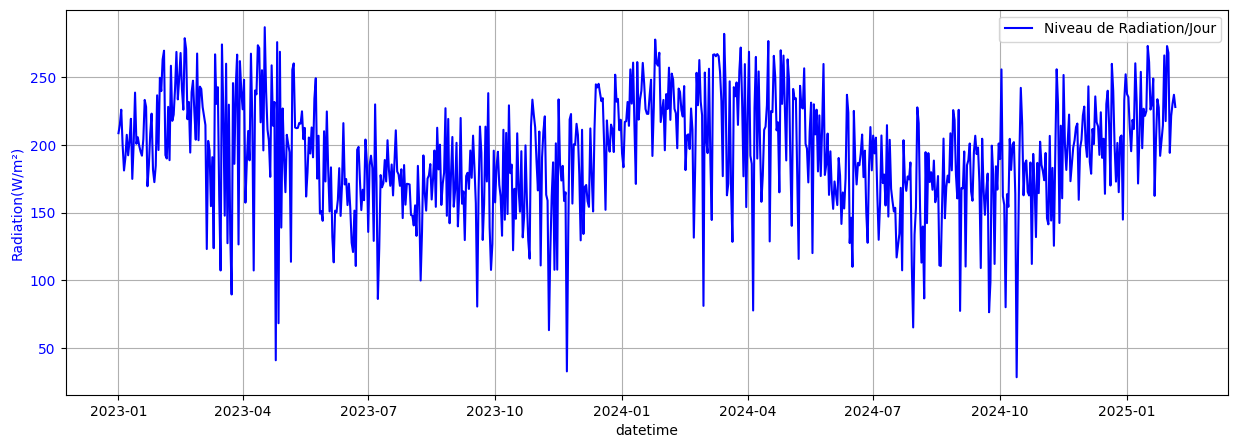

In [42]:
#Me permet de visualiser l'évolution de la radiation sur les 2.5 années
fig, ax1 = plt.subplots(1, figsize = (15, 5))

#Me permet de visualiser l'irradiation
sns.lineplot(data=df, x=df.index, y='Radiation', ax = ax1, color='b', label= "Niveau de Radiation/Jour")
plt.ylabel('Radiation(W/m²)', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.legend()
plt.savefig('1.jpg')

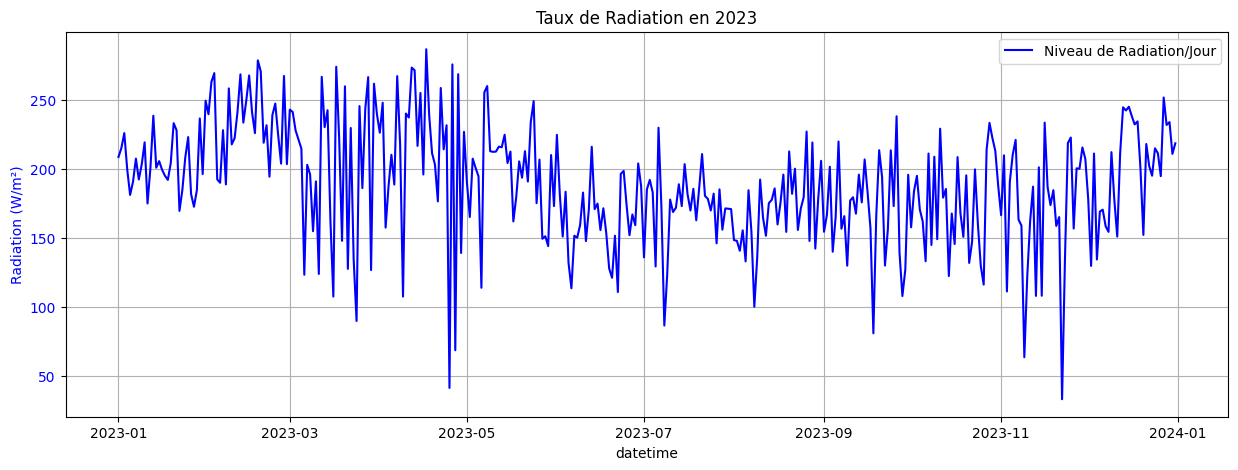

In [43]:
#Me permet de voir les données de l'année 2023
data_filtered = df['2023-01-01': '2023-12-31']

fig, ax1 = plt.subplots(1, figsize = (15, 5))

sns.lineplot(data=data_filtered, x='datetime', y='Radiation', ax=ax1, color='b', label='Niveau de Radiation/Jour')
ax1.set_ylabel('Radiation (W/m²)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.title('Taux de Radiation en 2023')
plt.legend()
plt.savefig('2.jpg')

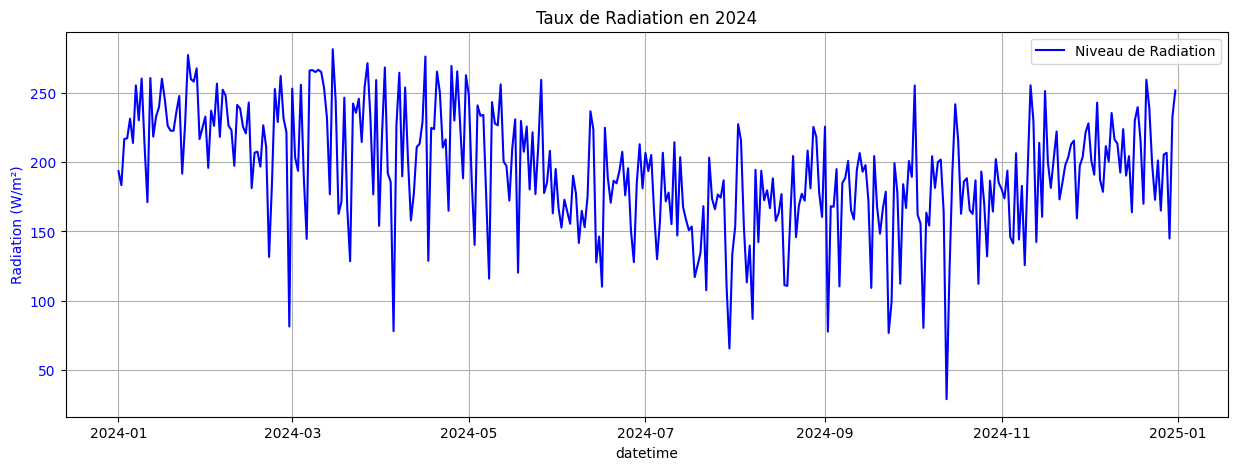

In [44]:
# Filter the data for the specified date range
data_filtered = df['2024-01-01': '2024-12-31']

# Initialize the plot
fig, ax1 = plt.subplots(1, figsize = (15, 5))

# Plot the GHI data
sns.lineplot(data=data_filtered, x='datetime', y='Radiation', ax=ax1, color='b', label='Niveau de Radiation')
ax1.set_ylabel('Radiation (W/m²)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.title('Taux de Radiation en 2024')
plt.legend()
plt.savefig('3.jpg')

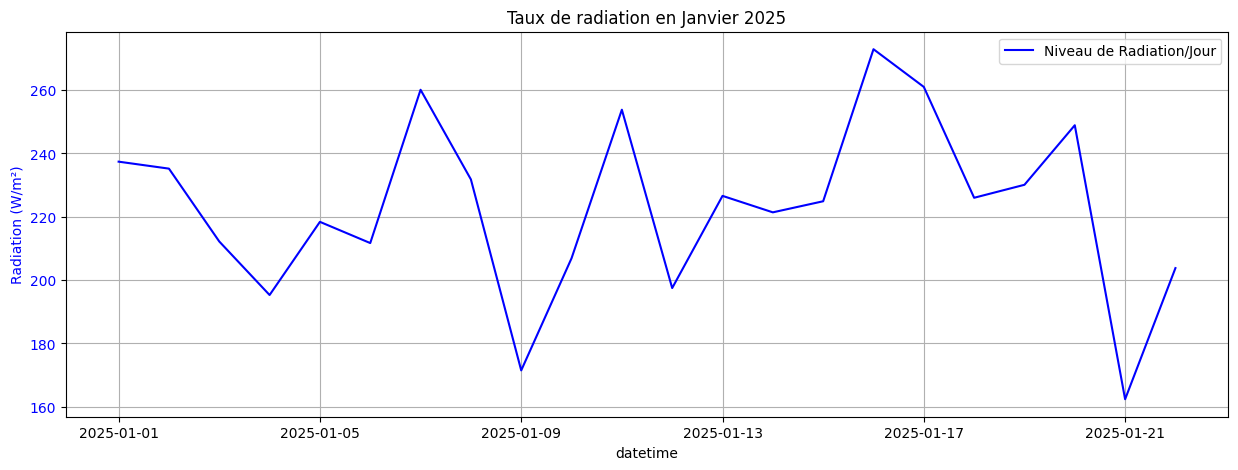

In [45]:
# Filter the data for the specified date range
data_filtered = df['2025-01-01': '2025-01-22']

# Initialize the plot
fig, ax1 = plt.subplots(1, figsize = (15, 5))

# Plot the GHI data
sns.lineplot(data=data_filtered, x='datetime', y='Radiation', ax=ax1, color='b', label='Niveau de Radiation/Jour')
ax1.set_ylabel('Radiation (W/m²)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.title('Taux de radiation en Janvier 2025')
plt.legend()
plt.savefig('4.jpg')

In [46]:
# Rééchantillonnage au début du mois et prise de la moyenne
m_df = df[['Radiation']].resample("MS").mean()
display(m_df.head(3))
# Rééchantillonnage à la semaine (à partir de lundi) et prise de la moyenne
w_df = df[['Radiation']].resample("W-MON").mean()
display(w_df.head(3))

Radiation
datetime              
2023-01-01  203.919355
2023-02-01  234.842857
2023-03-01  200.087097

Radiation
datetime              
2023-01-02  211.850000
2023-01-09  200.014286
2023-01-16  205.585714

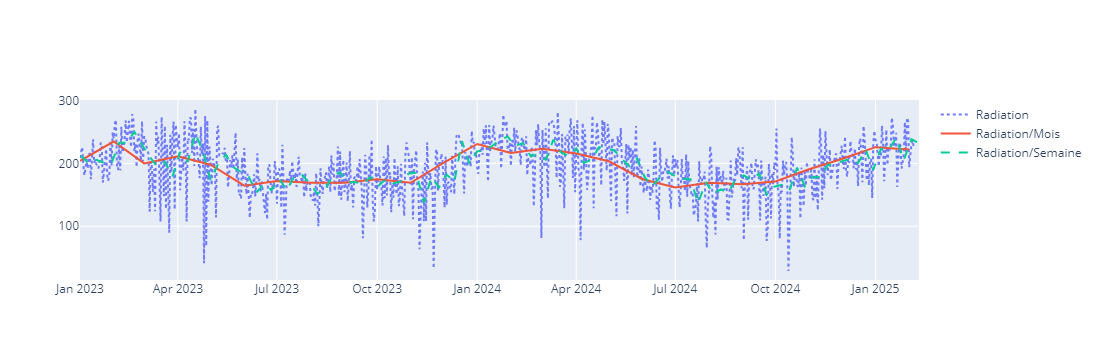

In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df.Radiation,
    opacity=0.9,
    name="Radiation",
    line={"dash": "dot"}
))

fig.add_trace(go.Scatter(
    x=m_df.index,
    y=m_df['Radiation'],
    opacity=1.0,
    name="Radiation/Mois",
    #line={"dash": "dashdot"}
))

fig.add_trace(go.Scatter(
    x=w_df.index,
    y=w_df['Radiation'],
    opacity=1,
    name="Radiation/Semaine",
    line={"dash": "dash"}
))

fig.show()

In [48]:
plot_df = df.loc[:, ['Radiation']]
# Avancer d'un jour
plot_df['Radiation_shift_1'] = df[["Radiation"]].shift(1)
# Reculer d'un jour
plot_df['Radiation_shift_-1'] = df[["Radiation"]].shift(-1)
#Me permet d'afficher le résultat
plot_df

Radiation  Radiation_shift_1  Radiation_shift_-1
datetime                                                    
2023-01-01      208.6                NaN               215.1
2023-01-02      215.1              208.6               225.9
2023-01-03      225.9              215.1               199.7
2023-01-04      199.7              225.9               181.1
2023-01-05      181.1              199.7               190.6
...               ...                ...                 ...
2025-02-01      194.1              267.8               221.3
2025-02-02      221.3              194.1               230.4
2025-02-03      230.4              221.3               236.9
2025-02-04      236.9              230.4               227.9
2025-02-05      227.9              236.9                 NaN

[767 rows x 3 columns]

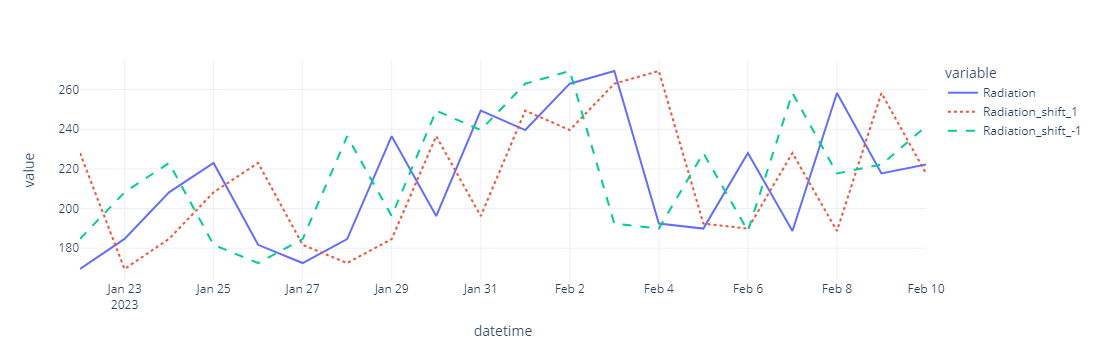

In [49]:
plot_df = plot_df.dropna().iloc[20:40].reset_index()
plot_df = pd.melt(plot_df, id_vars = 'datetime')
fig = px.line(plot_df, x="datetime", y="value", color="variable", line_dash="variable", template="plotly_white")
fig.show()

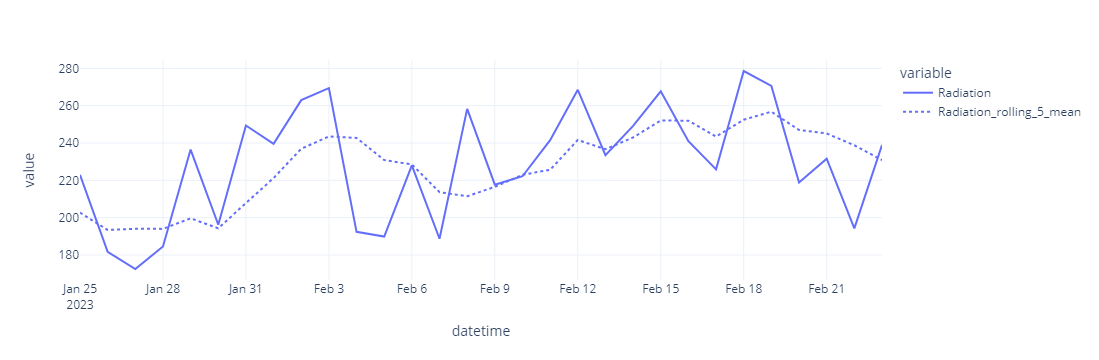

In [50]:
plot_df = df.loc[:, ['Radiation']]
# Moyenne mobile de 5 jours
plot_df["Radiation_rolling_5_mean"] = df[['Radiation']].rolling(window=5).mean()
plot_df = plot_df.dropna().iloc[20:50].reset_index()
plot_df = pd.melt(plot_df, id_vars="datetime")
fig = px.line(plot_df, x="datetime", y="value", line_dash="variable", template="plotly_white")
fig.show()

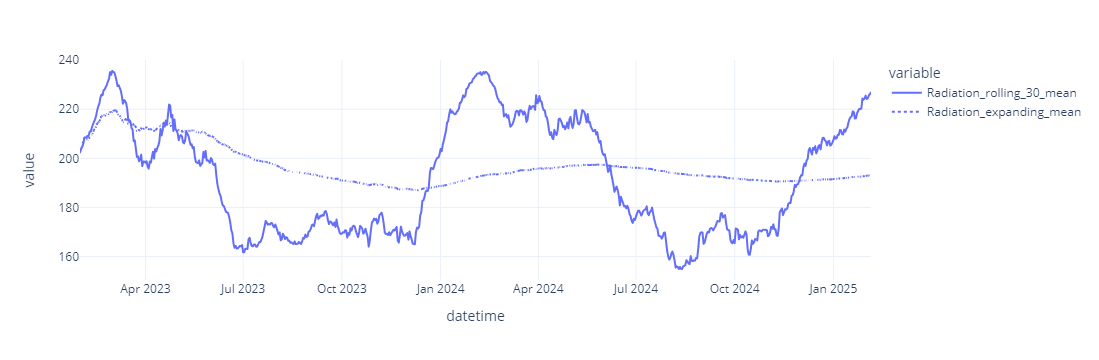

In [51]:
plot_df = df.loc[:, ['Radiation']]
# Moyenne mobile sur 30 jours
plot_df["Radiation_rolling_30_mean"] = df[['Radiation']].rolling(window=30).mean()
# Moyenne en Expansion
plot_df["Radiation_expanding_mean"] = df[['Radiation']].expanding().mean()
plot_df.drop(columns='Radiation', inplace=True)
plot_df = plot_df.dropna().reset_index()
plot_df = pd.melt(plot_df, id_vars="datetime")
fig = px.line(plot_df, x="datetime", y="value", line_dash="variable", template="plotly_white")
fig.show()

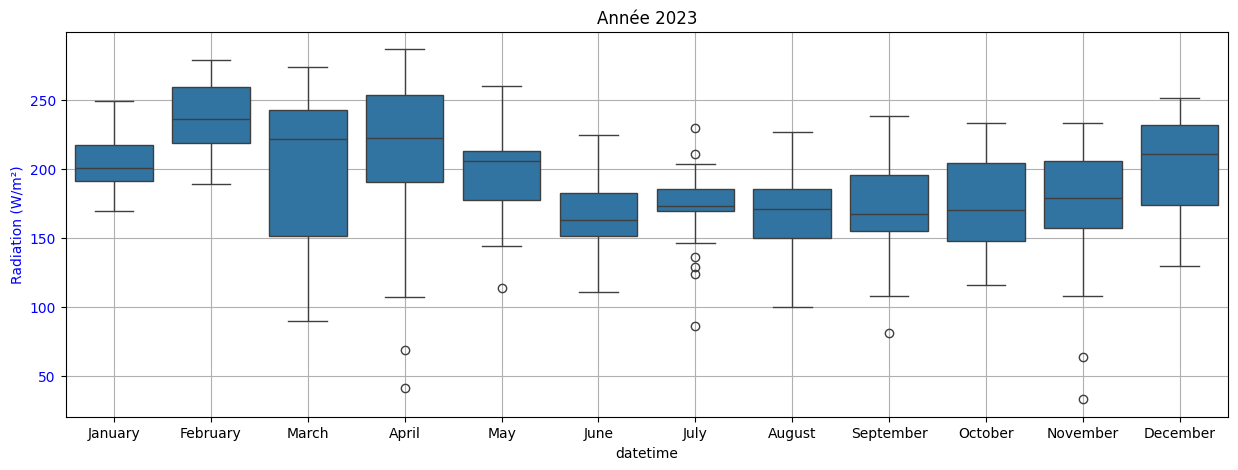

In [52]:
# Filter the data for the specified date range
data_filtered = df['2023-01-01': '2023-12-31']

# Initialize the plot
fig, ax1 = plt.subplots(1, figsize = (15, 5))

sns.boxplot(x = data_filtered.index.month_name(), y = 'Radiation', data = data_filtered)
plt.ylabel('Radiation (W/m²)', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.title('Année 2023')
plt.grid(True)
plt.savefig('9.jpg')

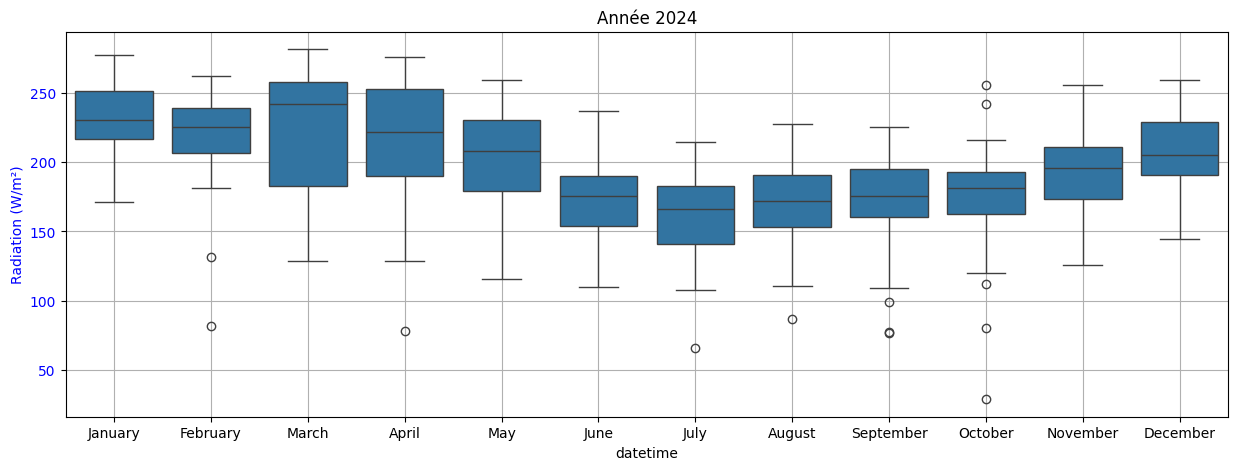

In [53]:
# Filter the data for the specified date range
data_filtered1 = df['2024-01-01': '2024-12-31']

# Initialize the plot
fig, ax1 = plt.subplots(1, figsize = (15, 5))

sns.boxplot(x = data_filtered1.index.month_name(), y = 'Radiation', data = data_filtered1)
plt.ylabel('Radiation (W/m²)', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.title('Année 2024')
plt.grid(True)
plt.savefig('10.jpg')

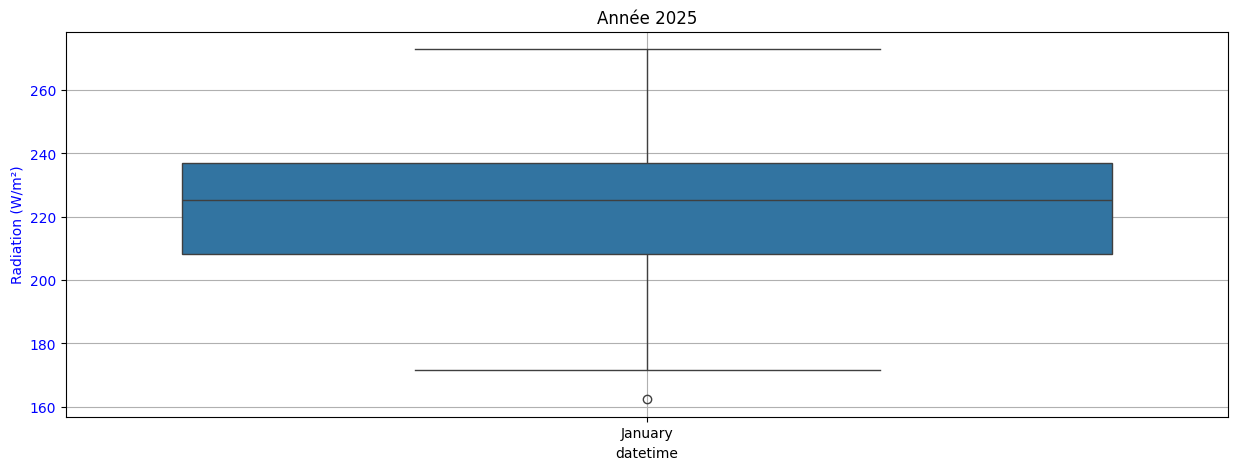

In [54]:
# Filter the data for the specified date range
data_filtered2 = df['2025-01-01': '2025-01-22']

# Initialize the plot
fig, ax1 = plt.subplots(1, figsize = (15, 5))

sns.boxplot(x = data_filtered2.index.month_name(), y = 'Radiation', data = data_filtered2)
plt.ylabel('Radiation (W/m²)', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.title('Année 2025')
plt.grid(True)
plt.savefig('11.jpg')

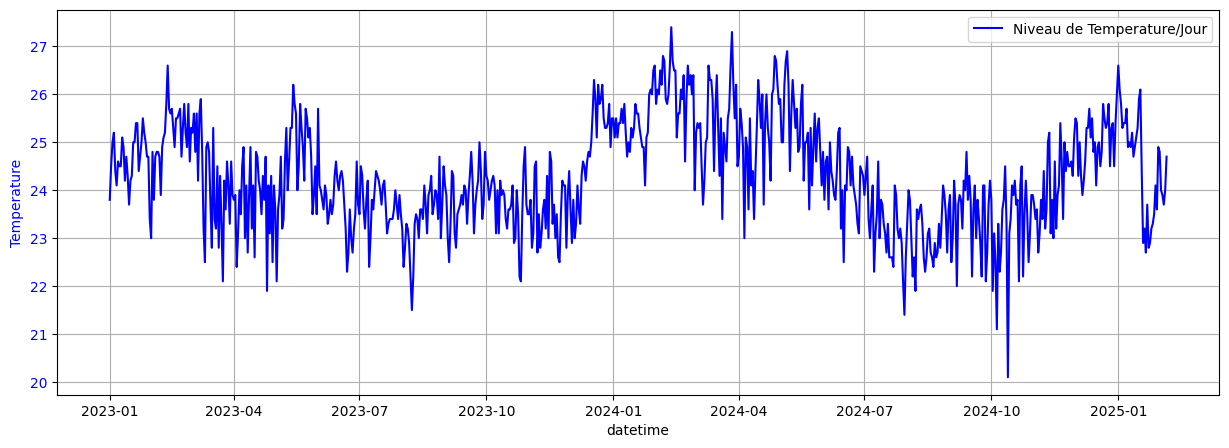

In [55]:
fig, ax1 = plt.subplots(1, figsize = (15, 5))

#Me permet de visualiser la temperature
sns.lineplot(data=df, x=df.index, y='Temperature', ax = ax1, color='b', label= "Niveau de Temperature/Jour")
plt.ylabel('Temperature', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.legend()
plt.savefig('temperature.jpg')

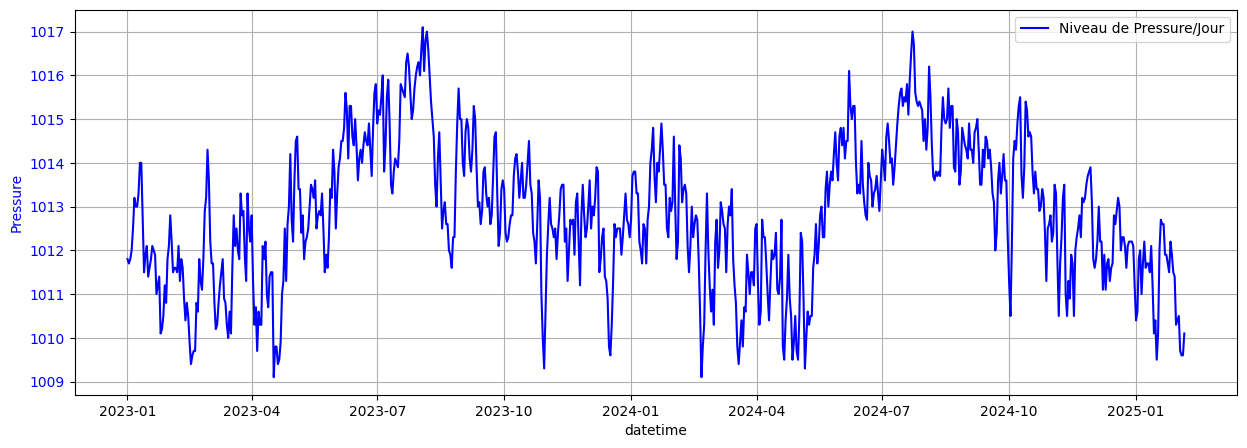

In [56]:
fig, ax1 = plt.subplots(1, figsize = (15, 5))

#Me permet de visualiser Pressure       
sns.lineplot(data=df, x=df.index, y='Pressure', ax = ax1, color='b', label= "Niveau de Pressure/Jour")
plt.ylabel('Pressure', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.legend()
plt.savefig('pressure.jpg')

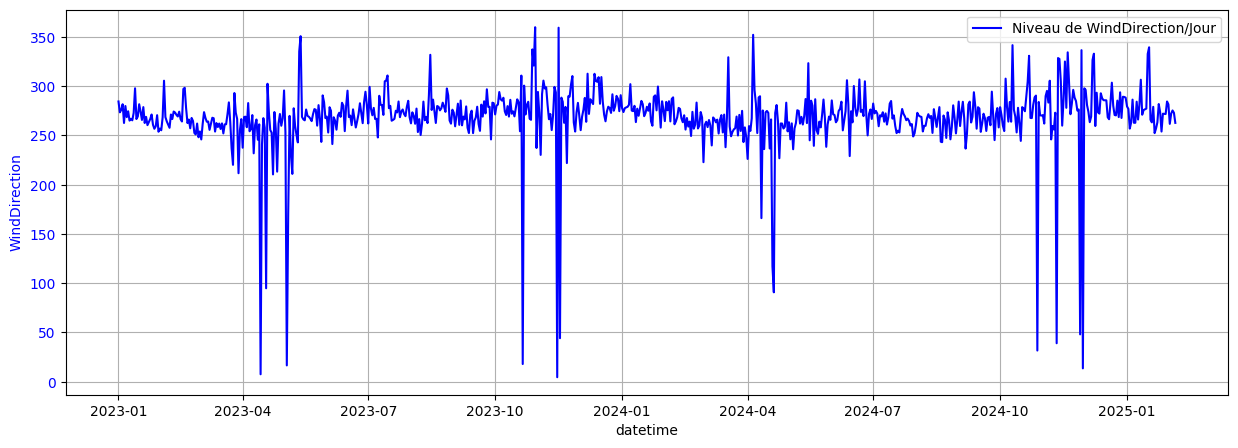

In [57]:
fig, ax1 = plt.subplots(1, figsize = (15, 5))

#Me permet de visualiser WindDirection       
sns.lineplot(data=df, x=df.index, y='WindDirection', ax = ax1, color='b', label= "Niveau de WindDirection/Jour")
plt.ylabel('WindDirection', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.legend()
plt.savefig('winddirection.jpg')

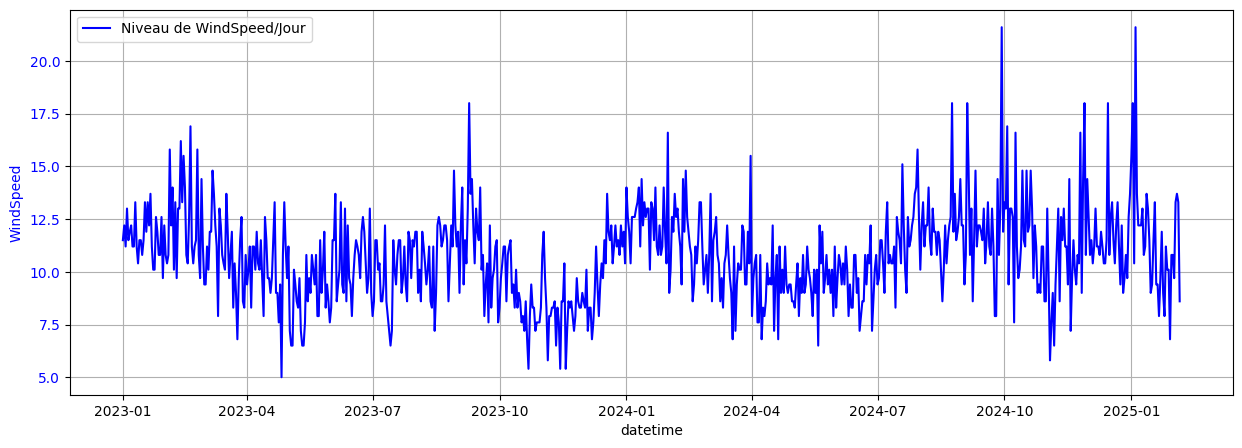

In [58]:
fig, ax1 = plt.subplots(1, figsize = (15, 5))

#Me permet de visualiser WindSpeed       
sns.lineplot(data=df, x=df.index, y='WindSpeed', ax = ax1, color='b', label= "Niveau de WindSpeed/Jour")
plt.ylabel('WindSpeed', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.legend
plt.savefig('WindSpeed.jpg')

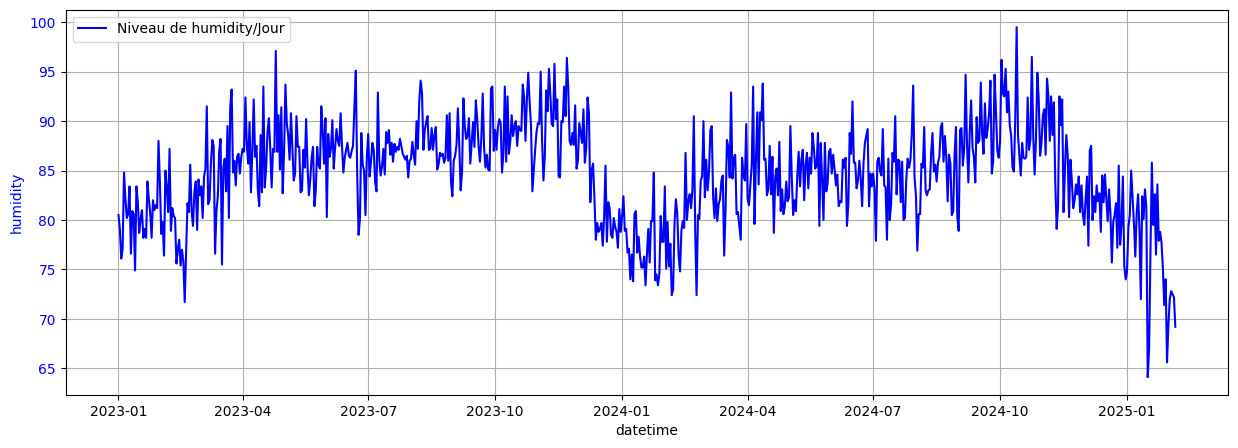

In [59]:
fig, ax1 = plt.subplots(1, figsize = (15, 5))

#Me permet de visualiser humidity       
sns.lineplot(data=df, x=df.index, y='humidity', ax = ax1, color='b', label= "Niveau de humidity/Jour")
plt.ylabel('humidity', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.grid(True)
plt.legend()
plt.savefig('humidity.jpg')

# <font color = '00008f'> <b> V- Etude statistique des données </b> <font/><a class = 'titre5' id = 'titre5'/>

## <font color = 'red'><b>1- Recherche des valeurs manquantes</b> <font/>

In [62]:
#Me permet de faire le rapport sur l'état des valeurs manquantes dans la base de données 
print("Rapport des Valeurs Manquantes :")
missing_values_report(df)

Rapport des Valeurs Manquantes :


Valeurs Manquantes  Pourcentage
Radiation                       0          0.0
Temperature                     0          0.0
humidity                        0          0.0
Pressure                        0          0.0
WindDirection                   0          0.0
WindSpeed                       0          0.0
sunrise                         0          0.0
sunset                          0          0.0

## <font color = 'red'><b>2- Recherche des valeurs abérrantes</b> <font/>

### <font color = 'green'><b>a- Le coefficient de variation</b> <font/>

In [65]:
#Nous constatons qu'il y'a des variables qui ne sont plus utiles ainsi nous pouvons supprimer certaines obsevations
df.drop(['sunrise', 'sunset'], axis = 1, inplace = True) 

In [66]:
#Me permet de récuperer les colonnes de la base de données étant déjà toutes numériques j'ai plus besoin de faire un découpage
columns = df.columns
columns

Index(['Radiation', 'Temperature', 'humidity', 'Pressure', 'WindDirection',
       'WindSpeed'],
      dtype='object')

In [67]:
#Me permet de calculer le Coefficient de Variation (Nous nous sommes déjà rassurés que toutes les valeurs sont continues)
coef_var = (df[columns].std())/(df[columns].mean())
p = pd.DataFrame(coef_var)
p.style.background_gradient()

In [68]:
#Me permet d'afficher les colonnes ayant une valeur de coef_var < 0.1
resultat_coef_var = coef_var[coef_var < 0.1].index.tolist()
print("Les variables avec un Coefficient de Variation < 0.1 sont : ", resultat_coef_var)

Les variables avec un Coefficient de Variation < 0.1 sont :  ['Temperature', 'humidity', 'Pressure']


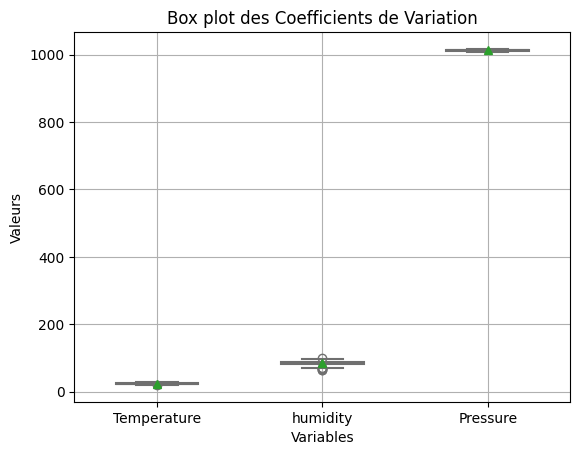

In [69]:
#Me permet de visualiser les IQR des variables Pressure, Year, risehour et sethour 
cv_variable = [df['Temperature'], df['humidity'], df['Pressure']]

sns.boxplot(
    data=cv_variable, 
    width=0.5, 
    palette='pastel', 
    showmeans=True,
    showfliers=True,
    linewidth=1.5
)

plt.title('Box plot des Coefficients de Variation')
plt.xlabel('Variables')
plt.ylabel('Valeurs')
plt.grid(True)
plt.savefig('12.jpg')

In [70]:
#Me permet d'afficher les colonnes ayant une valeur de coef_var > 0.1
resultat_coef_var1 = coef_var[coef_var > 0.1].index.tolist()
print("Les variables avec un Coefficient de Variation > 0.1 sont : ", resultat_coef_var1)

Les variables avec un Coefficient de Variation > 0.1 sont :  ['Radiation', 'WindDirection', 'WindSpeed']


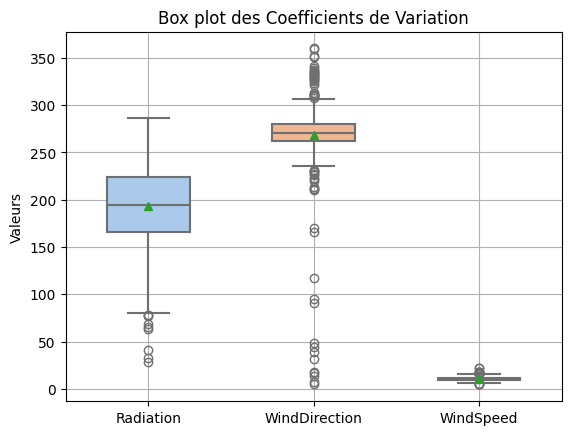

In [71]:
#Me permet de visualiser les IQR des variables Pressure
cv_variable1 = [df['Radiation'], df['WindDirection'], df['WindSpeed']]
sns.boxplot(
    data=cv_variable1, 
    width=0.5, 
    palette='pastel', 
    showmeans=True,
    showfliers=True,
    linewidth=1.5
)

plt.title('Box plot des Coefficients de Variation')
plt.ylabel('Valeurs')
plt.grid(True)
plt.savefig('coef_var1.jpg')
plt.show()

### <font color = 'green'><b>b- La méthode de l'Ecart-type</b> <font/>

In [73]:
#Elle permet d'afficher les variables ayant des valeurs abérrantes par la méthode de l'écart-type
std_outliers = detect_outliers_std(df, columns, seuil = 3)

In [74]:
#Affichage des valeurs abérrantes 
for col in columns:
    print("La variable", col, "possède:", std_outliers[col].shape[0], "Valeurs Abérrantes")    

La variable Radiation possède: 4 Valeurs Abérrantes
La variable Temperature possède: 1 Valeurs Abérrantes
La variable humidity possède: 5 Valeurs Abérrantes
La variable Pressure possède: 0 Valeurs Abérrantes
La variable WindDirection possède: 12 Valeurs Abérrantes
La variable WindSpeed possède: 8 Valeurs Abérrantes


### <font color = 'green'><b>c- La méthode de l'intervalle interquartile IQR</b> <font/>

In [76]:
#Elle permet d'afficher les varaibles ayant des valeurs abérrantes par la méthode de l'IQR
std_ouliers = detect_outliers_iqr(df, columns, k=1.5)

In [77]:
#Affichage des valeurs abérrantes 
for col in columns:
    print("La variable", col, "possède", std_outliers[col].shape[0], "Valeur(s) Abérrante(s)")

La variable Radiation possède 4 Valeur(s) Abérrante(s)
La variable Temperature possède 1 Valeur(s) Abérrante(s)
La variable humidity possède 5 Valeur(s) Abérrante(s)
La variable Pressure possède 0 Valeur(s) Abérrante(s)
La variable WindDirection possède 12 Valeur(s) Abérrante(s)
La variable WindSpeed possède 8 Valeur(s) Abérrante(s)


### <font color = 'green'><b>d- La méthode Isolation Forest</b> <font/>

In [79]:
#Me permet de définir le pipeline de traitement des données 
numerical_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy="median")), #Me permet d'imputer les valeurs manquantes par la mediane
    #Nous avons choisi l'imputation des données par la mediane car elle accepte les variables asymétriques et les valeurs abérrantes
    ('scaler', StandardScaler()) #Me permet de standardiser les variables 
])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
#Me permet de transformer les données dans le pipeline
preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_pipeline, columns)  
])

In [81]:
#Me permet d'appliquer le prétraitement du pipeline 
df_preprocess = preprocessor.fit_transform(df)

In [82]:
#Me permet d'initialiser la méthode de l'Isolation Forest pour la détection des valeurs abérrantes 
iso_forest = IsolationForest(contamination=0.0315, random_state=0)
#Me permet d'entrainer les données du pipeline dans le modèle isolation Forest
iso_forest.fit(df_preprocess)
#Me permet de prédire les variables ayant des valeurs manquantes
outliers_iso = iso_forest.predict(df_preprocess) == -1

In [83]:
#Me permet d'afficher les résultats avant suppression 
print("Avant Suppression : \n La méthode Isolation Forest a détecté : ", np.sum(outliers_iso), "Valeurs abérrantes")

Avant Suppression : 
 La méthode Isolation Forest a détecté :  25 Valeurs abérrantes


In [84]:
#Me permet d'afficher les résultats après suppression
df = df[~outliers_iso]
print("Après Suppression : \n Les nouvelles dimensions de la base de données sont :", df.shape)

Après Suppression : 
 Les nouvelles dimensions de la base de données sont : (742, 6)


In [85]:
#Me permet de voir la nouvelle base de données 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 742 entries, 2023-01-01 to 2025-02-05
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Radiation      742 non-null    float64
 1   Temperature    742 non-null    float64
 2   humidity       742 non-null    float64
 3   Pressure       742 non-null    float64
 4   WindDirection  742 non-null    float64
 5   WindSpeed      742 non-null    float64
dtypes: float64(6)
memory usage: 40.6 KB


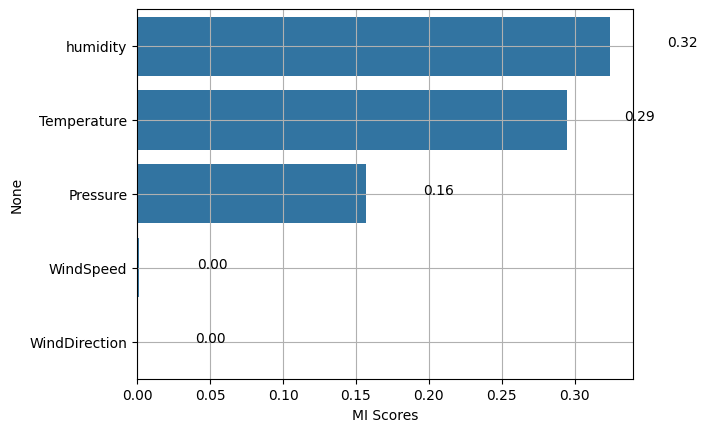

In [86]:
#Me permet de voir le degré d'information qu'il y'a entre les différentes variables et la cible 
#Pour celà nous allons utiliser la méthode Mutual Information pour la radiation
mi_scores = make_mi_scores(df.drop("Radiation", axis=1), df["Radiation"]) 
plot_scores(mi_scores, "Mutual Information Scores")

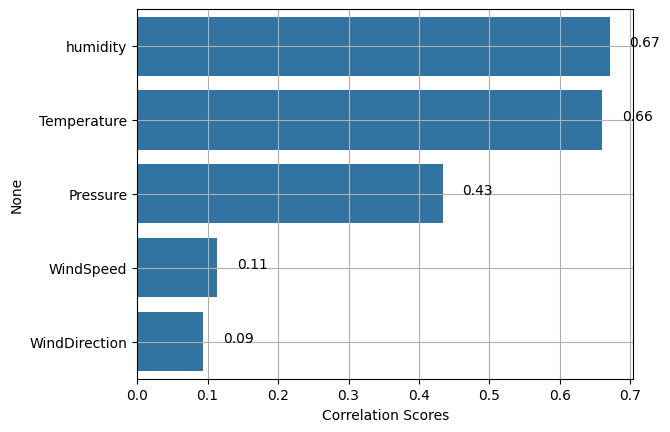

In [87]:
#Me permet de voir la corrélation entre la variable cible Radiation et les autres variables 
corr_scores = make_corr_scores(df.drop("Radiation", axis=1), df["Radiation"]) 
plot_scores(corr_scores, "corr") 

**Conclusion** : la figure ci-haut permet de constater que la variable **Temperature et humudity** possèdent un fort taux de corrélation avec la variable cible **Radiation**

# <font color = '00008f'><b> VI-Analyse Univariée des variables </b><font/>

In [90]:
#Me permet de calculer toutes les mesures nécessaires
resultat_des_calculs = pd.DataFrame(pourcentage(df))
resultat_des_calculs.style.background_gradient()

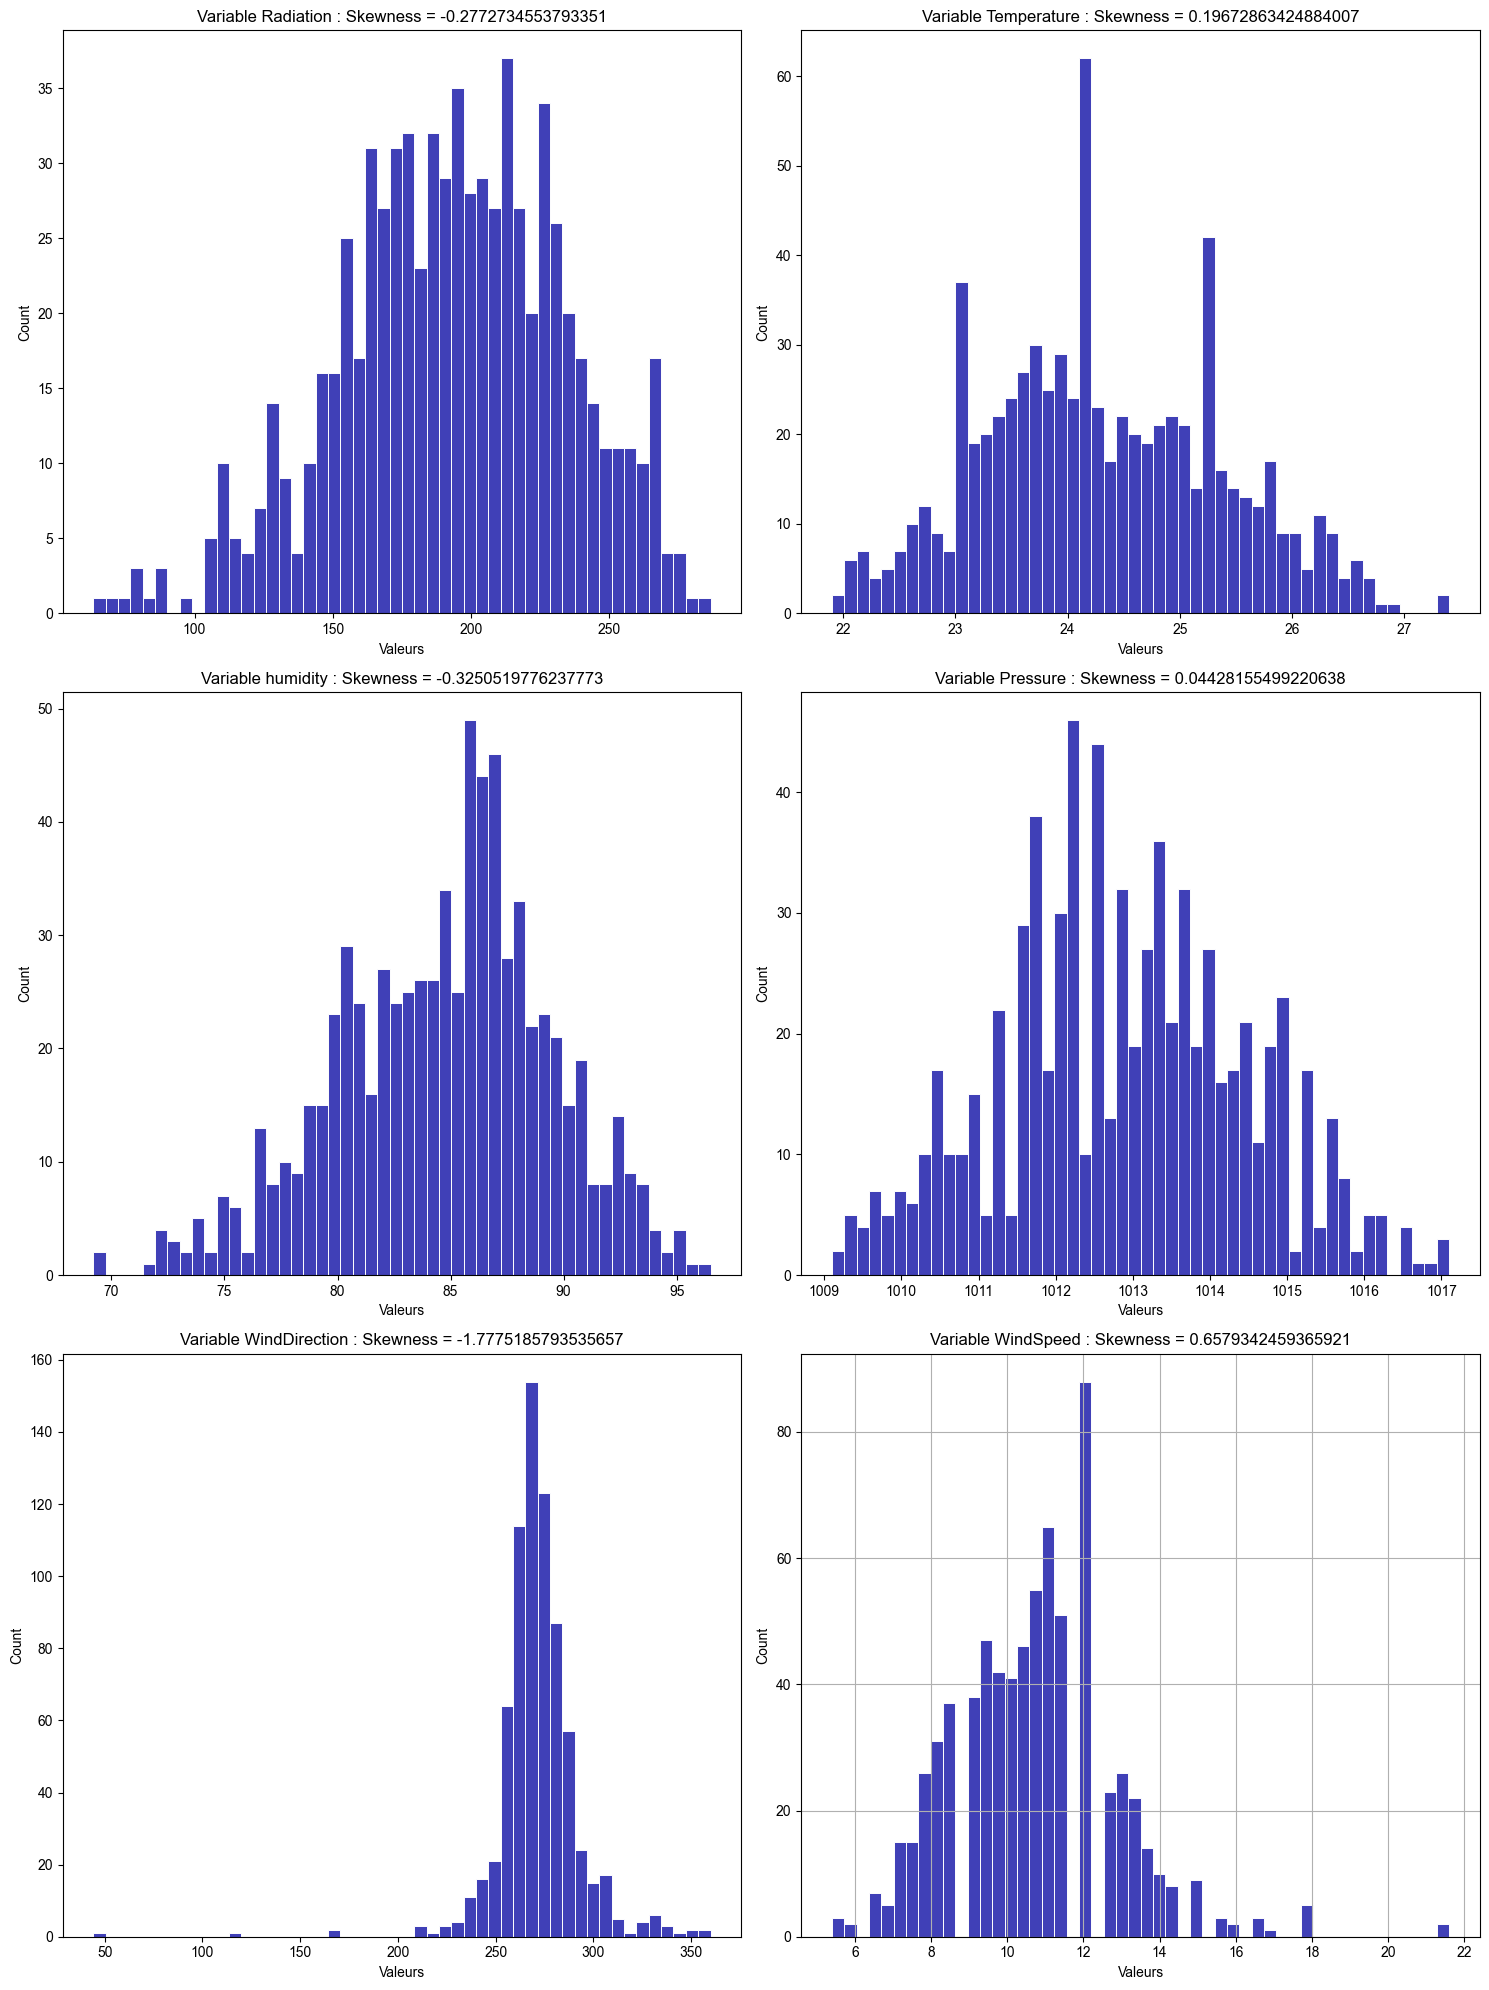

In [91]:
#Me permet de visualiser et confimer les hypothèses ci-dessus 
#Me permet de récuperer toutes les valeurs réels
features = df.select_dtypes(include=['float64', 'int32', 'int64'])
#Me permet de déssiner une matrice de 3 lignes et 2 colonnes
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (15,20))
#Me permet d'attribuer un style à la présentation visuelle 
sns.set_style("whitegrid")
axs = axs.flatten()

#Me permet de parcourir les colonnes et de les afficher une par une avec la valeur de la mesure asymétrique skewness 
#Elle me permet de voir l'asymétrie de la variable et de mieux préparation les transformations
for i, feat in enumerate(features):
    sns.histplot(data=df, x=feat, ax=axs[i], color='#00009f', bins=50)
    axs[i].set_xlabel('Valeurs')
    axs[i].set_title(f'Variable {feat} : Skewness = {df[feat].skew()}')
    plt.grid(True)

plt.tight_layout()
plt.savefig('16.jpg')
plt.show()

In [92]:
#Me permet de délimiter et de voir les variables qui sont une distribution asymétrique supérieur à 0.5
skew_limit = 0.5
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals) > skew_limit].sort_values(ascending=False)
skew_cols = pd.DataFrame(skew_cols)
skew_cols.style.background_gradient()

# <font color = '00008f'><b> VII- Analyse Bivariée des variables </b><font/>

In [94]:
#Séparation des données en features et target
#Il contient la cible
target = df['Radiation']
#Il contient les autres variables sauf la variable Radiation
features = df.drop('Radiation', axis=1)

## <font color = 'red'><b>1- Selection des features par la matrice de corrélation</b><font/><a class = 'anchor' id = 'correlation_matrix'/>

In [96]:
#Me permet de déterminer la corrélation entre les variables
display(df.corr(method='pearson').style.background_gradient())

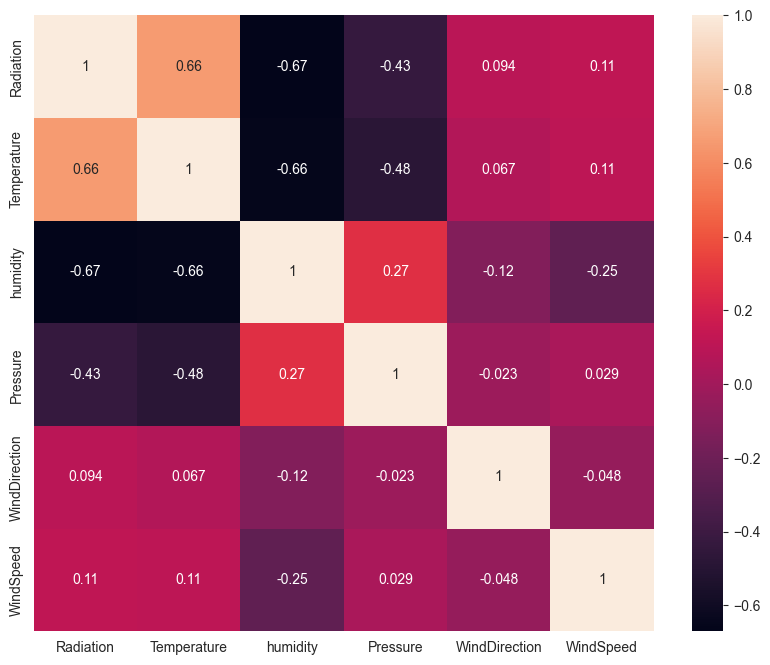

In [97]:
#Affichons celà dans un heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(method="pearson"), annot=True)
plt.savefig('17.jpg')
plt.show()

In [98]:
#Me permet de générer la corrélation entre la variable radiation et chacune des autres variables
corr = pd.DataFrame(df.corrwith(df['Radiation']))
#Me permet d'ajouter les colonnes dans le dataframe 
corr.columns = ['Feature_important']
#Me permet de supprimer la varibale Radiation dans le dataframe
corr = corr.drop('Radiation', axis = 0)
#Me permet d'afficher le résultat de la variable corr
features_score_corr = corr
corr.style.background_gradient()

**CONCLUSION** : Nous remarquons que la variable **temperature et radiation** ont une forte corrélation importante ainsi que **radiation et humidity** ont une corrélation importante

## <font color = 'red'><b>2-Selection des features en utilisant la méthode SelectKBest</b><font/><a class = 'anchor' id = 'kbest_method'/>

In [101]:
#affichons la sortie target 
target

datetime
2023-01-01    208.6
2023-01-02    215.1
2023-01-03    225.9
2023-01-04    199.7
2023-01-05    181.1
              ...  
2025-02-01    194.1
2025-02-02    221.3
2025-02-03    230.4
2025-02-04    236.9
2025-02-05    227.9
Name: Radiation, Length: 742, dtype: float64

In [102]:
#Me permet d'utiliser LabelEncoder
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)

<IPython.core.display.Javascript object>

In [103]:
# multiplions les données par 100 et ensuite
# nous allons convertir en type int qui va permettre d'être traiter comme des étiquettes par le modèle
# nous aurions pu le faire aussi avec labelencoder
target_cont = df['Radiation'].apply(lambda x : int(x*100))
print(target_cont)

datetime
2023-01-01    20860
2023-01-02    21510
2023-01-03    22590
2023-01-04    19970
2023-01-05    18110
              ...  
2025-02-01    19410
2025-02-02    22130
2025-02-03    23040
2025-02-04    23690
2025-02-05    22790
Name: Radiation, Length: 742, dtype: int64


In [104]:
# mise en echelle et transformation des features par la mise à l'échelle Min-Max
scaled_features = MinMaxScaler().fit_transform(features)
scaled_features

<IPython.core.display.Javascript object>

array([[0.34545455, 0.41391941, 0.3375    , 0.76116566, 0.37654321],
       [0.47272727, 0.36263736, 0.325     , 0.72632246, 0.41975309],
       [0.56363636, 0.25274725, 0.3375    , 0.73424137, 0.35802469],
       ...,
       [0.32727273, 0.12087912, 0.0625    , 0.73234083, 0.51234568],
       [0.38181818, 0.10989011, 0.0625    , 0.72473868, 0.48765432],
       [0.50909091, 0.        , 0.125     , 0.69242952, 0.19753086]])

In [105]:
#Exécutons la méthode SelectKBest()
#Select est une méthode de sélection de caractéristiques couramment utilisée dans le ML. 
#il s'agit d'une méthode de selection par un filtre qui peut être un test du chi carré ou le test F ou encore d'ANOVA
#Lorsque nous avons à faire à une regression nous pouvons utiliser f_regression, mutual_info_regression
#Lorsque nous avons à faire à une classification nous pouvons utiliser chi2, f_classif, mutual_info_classif
best_features = SelectKBest(score_func = f_regression, k = 5)
fit = best_features.fit(scaled_features, target_cont)

In [106]:
#Me permet de déterminer le score de chaque features
scores = pd.DataFrame(fit.scores_)
#Me permet de faire corréler le score de chaque features
column = pd.DataFrame(features.columns)

In [107]:
#faisons une concaténation des scores et des column obtenus
features_scores_bestselect = pd.concat([column, scores], axis=1)
#renomons les colonnes du dataframe 
features_scores_bestselect.columns = ['Features', 'Feature_important']

In [108]:
#affichons les meilleurs features triés par le score 
features_scores_bestselect.sort_values(by = 'Feature_important', ascending=False, inplace=True)
features_selectbest = features_scores_bestselect
features_scores_bestselect.style.background_gradient()

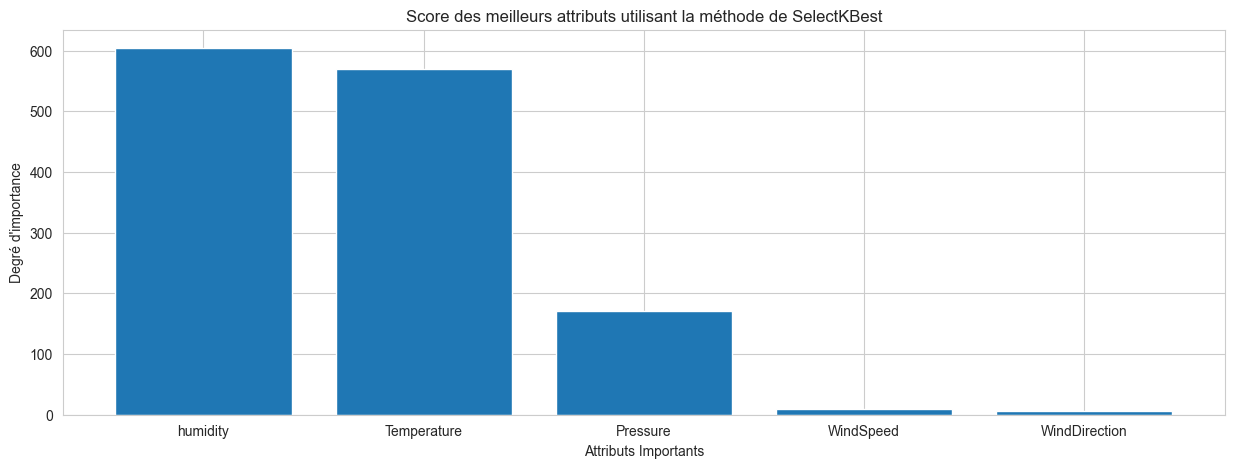

In [109]:
#Visualisons les features importantes 
plt.figure(figsize=(15, 5))
plt.grid(True)
plt.bar(features_scores_bestselect.Features, features_scores_bestselect.Feature_important)
plt.xticks(rotation = 0)
plt.xlabel("Attributs Importants")
plt.ylabel("Degré d'importance")
plt.title("Score des meilleurs attributs utilisant la méthode de SelectKBest")
plt.savefig('18.jpg')
plt.show()

**Conclusion** : Nous constatons que la variable **Humidity** possède un fort score comme feature important 

## <font color = 'red'><b>3-Selection des features en utilisant la méthode xgboost</b><font/><a class = 'anchor' id = 'kbest_method'/>

In [112]:
#Me permet de mettre en place le modèle xgb
features_xgboost = xgb.XGBRegressor(base_score=0.5, 
                                    booster = 'gbtree',
                                    n_estimators = 1000, 
                                    objective = 'reg:linear', 
                                    max_depth = 3,
                                    learning_rate = 0.01)

<IPython.core.display.Javascript object>

In [113]:
features_xgboost.fit(scaled_features, target_cont, verbose = 100)

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning:

[07:59:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

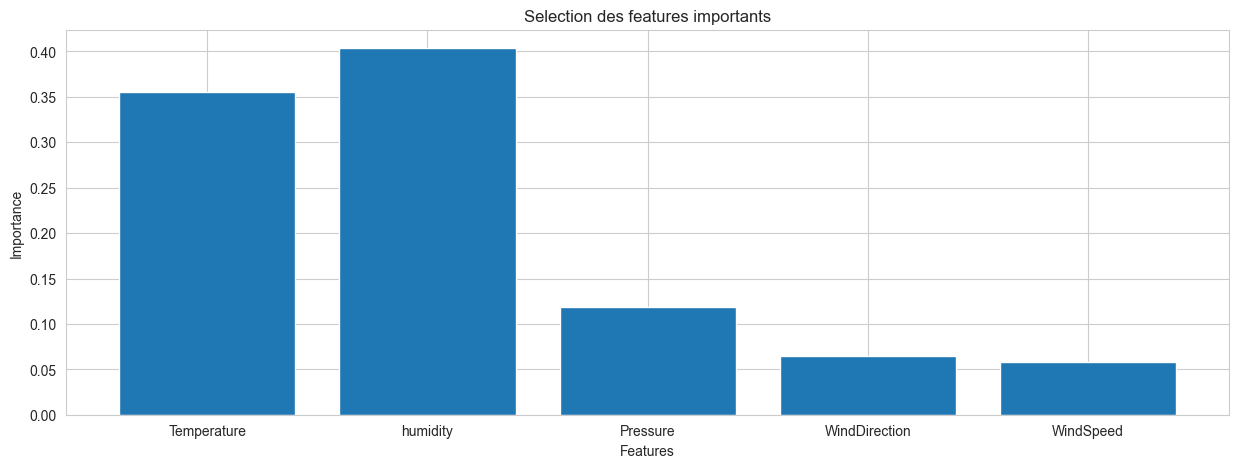

In [114]:
#Me permet de visualiser les features importants
plt.figure(figsize = (15, 5))
plt.bar(features.columns, features_xgboost.feature_importances_)
plt.xticks(rotation = 0)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Selection des features importants")
plt.grid(True)
plt.savefig('19.jpg')

## <font color = 'red'><b>4-Selection des features en utilisant la méthode DecisionTreeClassifier</b><font/><a class = 'anchor' id = 'kbest_method'/>

In [116]:
#Me permet de créer une variable pour le modèle DecisionTreeClassifier
features_scores_rfe = DecisionTreeClassifier()

#Me permet de créer un modèle RFE
rfe = RFE(estimator = features_scores_rfe, n_features_to_select = 5, step = 1)
rfe = rfe.fit(scaled_features, target_cont)

In [117]:
#Me permet d'afficher le résultat
print('Les 5 meilleures features sont :', features.columns[rfe.support_])

Les 5 meilleures features sont : Index(['Temperature', 'humidity', 'Pressure', 'WindDirection', 'WindSpeed'], dtype='object')


In [118]:
#Me permet de mettre le résultat dans un dataframe 
features_important_rfe = pd.DataFrame({
    'Feature': list(features.columns), 
    'rang': rfe.ranking_
})

features_important_rfe.sort_values(by = 'rang').style.background_gradient()

In [119]:
#DecisionTreeClassifier est un ensemble d'algorithmes d'apprentissage 
#automatique de type "forêt d'arbres décisionnels" utilisé pour la classification
#Me permet de faire appel au model de DecisionTreeClassifier
model_feat = DecisionTreeClassifier(random_state = 1)
model_feat

DecisionTreeClassifier(random_state=1)

In [120]:
#Me permet d'entrainer le nouveau modèle
model_feat.fit(scaled_features, target_cont)

DecisionTreeClassifier(random_state=1)

In [121]:
feature_importances_dt = pd.DataFrame(model_feat.feature_importances_, features.columns, columns = ["feature_important"])
feature_importances_dt.sort_values(by = 'feature_important', ascending=False, inplace = True)
feature_importances_dt.style.background_gradient()

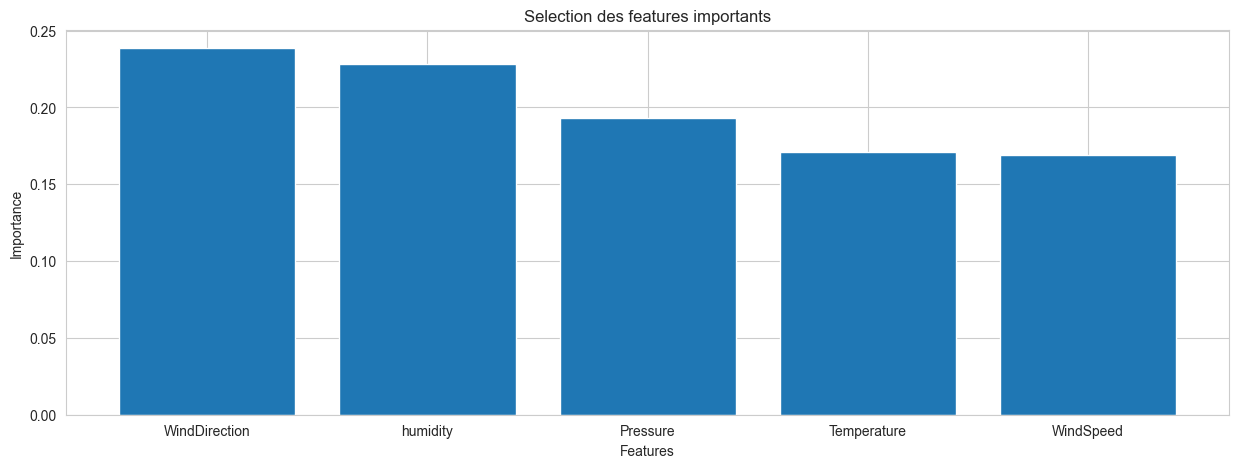

In [122]:
plt.figure(figsize = (15, 5))
plt.bar(feature_importances_dt.index, feature_importances_dt["feature_important"])
plt.xticks(rotation = 0)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Selection des features importants")
plt.grid(True)
plt.savefig('20.jpg')

## <font color = 'red'><b>5-Selection des features en utilisant la méthode DecisionTreeClassifier + RFECV</b><font/><a class = 'anchor' id = 'kbest_method'/>

In [124]:
#Me permet de créer une variable pour le modèle DecisionTreeClassifier
features_rfcv = DecisionTreeClassifier()

#Me permet de créer un modèle  RFECV
kf = KFold(n_splits = 5, shuffle=True, random_state=5)
rfecv = RFECV(estimator = features_rfcv, step = 1, cv = kf, scoring='accuracy')
rfecv = rfecv.fit(scaled_features, target_cont)

#Me permet d'afficher le résultat de l'entrainement
print('Nombre de features optimal :', rfecv.n_features_)
print('Les Meilleurs feautres sont :', features.columns[rfecv.support_])

<IPython.core.display.Javascript object>

Nombre de features optimal : 2
Les Meilleurs feautres sont : Index(['humidity', 'WindDirection'], dtype='object')


In [125]:
features_important_rfecv = pd.DataFrame({'Feature': list(features.columns),
                              'rang': rfecv.ranking_,
                              'score': rfecv.cv_results_['mean_test_score']})
features_important_rfecv.sort_values(by = 'rang').style.background_gradient()

## <font color = 'red'><b>6- Sélection des features par l'Analyse en Composante principale (ACP)</b><font/>

In [127]:
#Me permet de récuperer les valeurs de la base de donnéees
x = df.values

In [128]:
#Me permet de récuperer les index de la base de données 
names = df.index

In [129]:
#Me permet de récuperer les colonnes venant de la base de données
features = df.columns

In [130]:
#Me permet de standardiser les données de x
scaler = StandardScaler()

<IPython.core.display.Javascript object>

In [131]:
#Me permet de transformer et entrainer les données standard
x_scaled = scaler.fit_transform(x)

In [132]:
#Me permet de voir les efffets de la standardisation
#Me permet de voir si la moyenne = 0 et l'écart type = 1
idx = ['mean', 'std']
pd.DataFrame(x_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5
mean -0.0  0.0 -0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0

<IPython.core.display.Javascript object>

5 Composants principaux expriment 90% de la base de données
5 Composants principaux expriment 95% de la base de données
6 Composants principaux expriment 99% de la base de données


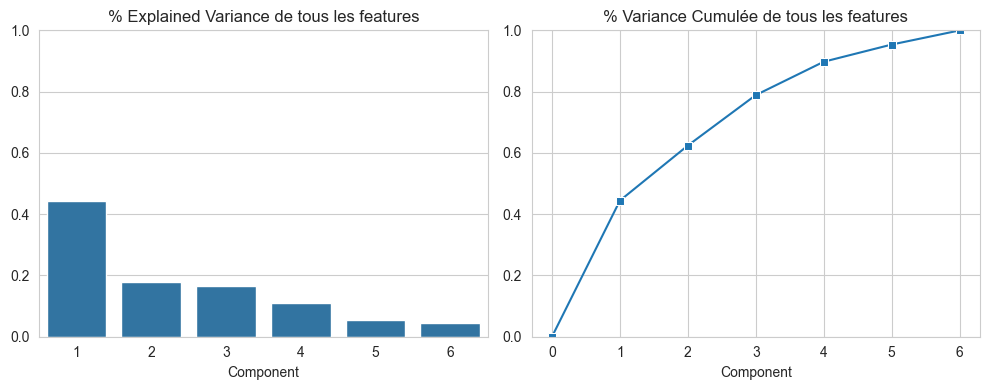

In [133]:
#Me permet de créer un modèle ACP 
pca = PCA()

#Me permet de créer le composant principal
x_pca = pca.fit_transform(x_scaled)

#Me permet de convertir en dataframe 
component_names = [f"PC{i+1}" for i in range(x_pca.shape[1])]

x_pca = pd.DataFrame(x_pca, columns = component_names, index = df.index)

#Me permet de faire les courbes qui vont suivre 
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
n = pca.n_components_ 
grid = np.arange(1, n+1)

#Me permet de calculer et tracer la courbe de la variance de chaque composants 
evr = pca.explained_variance_ratio_ 
sns.barplot(x=grid, y = evr, ax = axs[0]) 
plt.grid(True)
axs[0].set(xlabel = "Component", title="% Explained Variance de tous les features", ylim = (0.0, 1.0)) 

#Me permet de calculer et tracer la variance cumulée 
cum_variance = np.cumsum(evr) 
sns.lineplot(x = np.r_[0, grid], y = np.r_[0, cum_variance], marker = "s", ax = axs[1]) 
plt.grid(True)
axs[1].set(xlabel = "Component", title="% Variance Cumulée de tous les features", ylim = (0.0, 1.0)) 
fig.tight_layout()

#Me permet de calculer le nombre de composant celon le pourcentage 
pca_90 = np.argmax(cum_variance >= 0.90) 
pca_95 = np.argmax(cum_variance >= 0.95) 
pca_99 = np.argmax(cum_variance >= 0.99)

#Me permet d'afficher les résultats celon les pourcentages
print(pca_90+1, "Composants principaux expriment 90% de la base de données") 
print(pca_95+1, "Composants principaux expriment 95% de la base de données") 
print(pca_99+1, "Composants principaux expriment 99% de la base de données") 

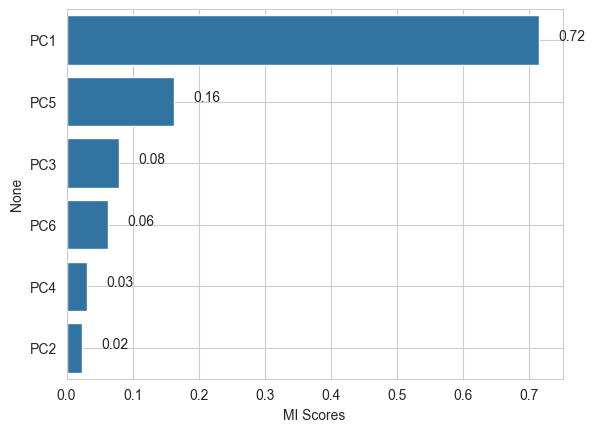

In [134]:
#Me permet de visualiser les composantes importantes par rapport à la variable cible
mi_scores = make_mi_scores(x_pca, df['Radiation'])
plot_scores(mi_scores, "Mutual Information Scores")

In [135]:
#Me permet de créer un modèle pca avec 5 composantes
n_components = 5
pca = PCA(n_components = n_components) 
#Me permet d'entrainer le modèle 
pca.fit(x_scaled)

<IPython.core.display.Javascript object>

PCA(n_components=5)

In [136]:
 #Me permet de définir une variable avec la liste de nos composantes 
x_list = range(1, n_components + 1) 
list(x_list)

[1, 2, 3, 4, 5]

In [137]:
scree = (pca.explained_variance_ratio_*100).round(2) 
scree

array([44.45, 17.97, 16.47, 10.88,  5.61])

In [138]:
#Me permet de faire une somme cumulée des pourcentages
scree_cum = scree.cumsum().round() 
scree_cum

array([44., 62., 79., 90., 95.])

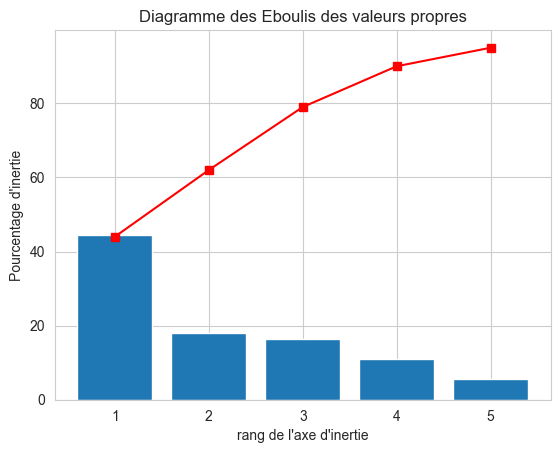

In [139]:
#Me peremt d'afficher l'Eboulis des valeurs propres
plt.bar(x_list, scree) 
plt.plot(x_list, scree_cum, c = "red", marker = 's') 
plt.xlabel("rang de l'axe d'inertie") 
plt.ylabel("Pourcentage d'inertie") 
plt.title("Diagramme des Eboulis des valeurs propres") 
plt.grid(True)
plt.savefig('21.jpg') 

In [140]:
#Me permet d'afficher les 5 composantes 
pcs = pca.components_
pcs

array([[-0.53050826, -0.53455315,  0.51336635,  0.37642453, -0.08830273,
        -0.14062755],
       [-0.03615756, -0.05081476, -0.17661281,  0.32731186, -0.42068252,
         0.82511306],
       [ 0.01891864,  0.08909362,  0.15692426, -0.36399059, -0.87520541,
        -0.26192656],
       [-0.22022519, -0.10713295,  0.36582039, -0.73674221,  0.21715899,
         0.46502873],
       [ 0.71934847, -0.68610736,  0.08060008, -0.06632567, -0.01916048,
         0.02306255]])

In [141]:
#Me permet de transformer la variable des composantes en dataframe
pcs = pd.DataFrame(pcs)
pcs

0         1         2         3         4         5
0 -0.530508 -0.534553  0.513366  0.376425 -0.088303 -0.140628
1 -0.036158 -0.050815 -0.176613  0.327312 -0.420683  0.825113
2  0.018919  0.089094  0.156924 -0.363991 -0.875205 -0.261927
3 -0.220225 -0.107133  0.365820 -0.736742  0.217159  0.465029
4  0.719348 -0.686107  0.080600 -0.066326 -0.019160  0.023063

In [142]:
#Me permet d'afficher les composants avec les noms des features 
col = df.columns 
pcs.columns = col 
pcs.index = [f"F{i}" for i in x_list] 
pcs.round(2)

Radiation  Temperature  humidity  Pressure  WindDirection  WindSpeed
F1      -0.53        -0.53      0.51      0.38          -0.09      -0.14
F2      -0.04        -0.05     -0.18      0.33          -0.42       0.83
F3       0.02         0.09      0.16     -0.36          -0.88      -0.26
F4      -0.22        -0.11      0.37     -0.74           0.22       0.47
F5       0.72        -0.69      0.08     -0.07          -0.02       0.02

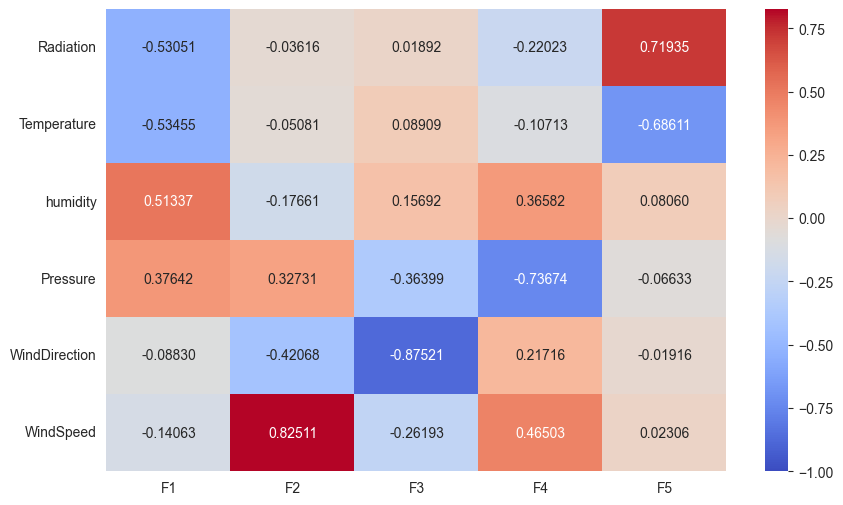

In [143]:
#Me permet d'avor une représentation visuelle 
fig, ax = plt.subplots(figsize = (10, 6)) 
sns.heatmap(pcs.T, vmin = -1, annot = True, cmap = "coolwarm", fmt = "0.5f") 
plt.savefig('22.jpg')

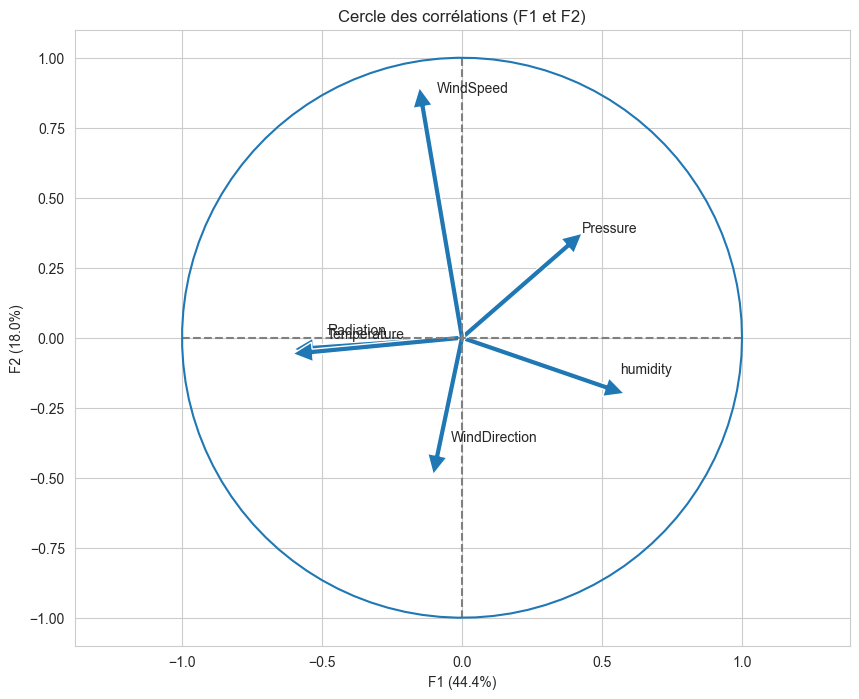

In [144]:
#Me permet de définir les composants qui seront affichés F1 et F2
x_y = (0, 1)
x_y

#Me permet d'appeler la fonction qui permet d'afficher le cercle de corrélations 
correlation_graph(pca, x_y, col)

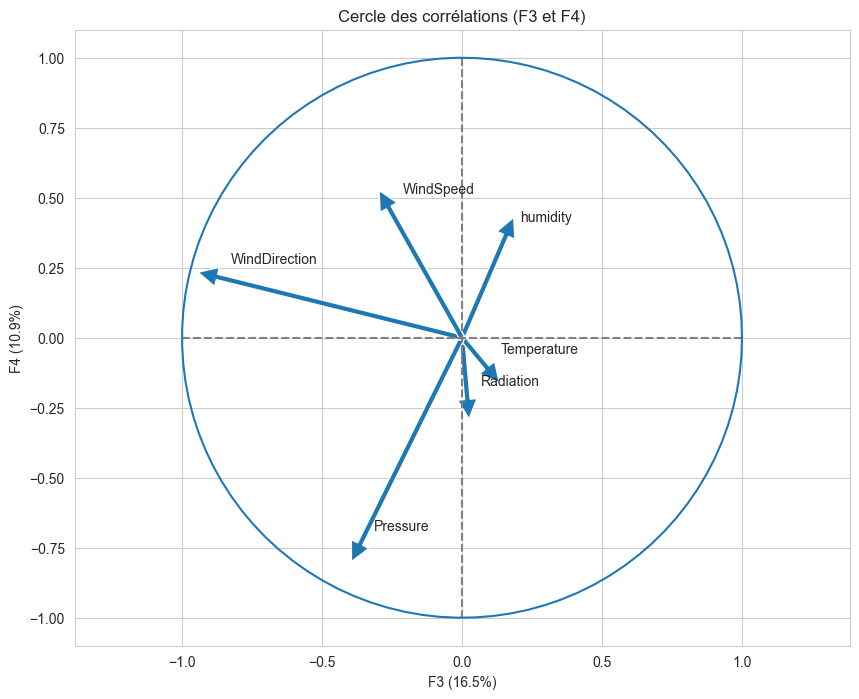

In [145]:
#Me permet de définir les composants qui seront affichés F2 et F3
x_y = (2, 3)
x_y

#Me permet d'appeler la fonction qui permet d'afficher le cercle de corrélations 
correlation_graph(pca, x_y, col)

In [146]:
#Me permet de gérer la projection de nos dimensions
x_proj = pca.transform(x_scaled)
x_proj[:5]

array([[-0.76527545,  0.00336718, -0.55080897,  0.44732735,  0.56556142],
       [-1.3773719 ,  0.48512295, -0.15039654,  0.32322582,  0.22829903],
       [-2.01304409,  0.14359338, -0.20337922, -0.25774874,  0.02990869],
       [-1.75877231,  0.7534165 , -0.66780284,  0.30297574, -0.54029789],
       [ 0.01320355,  0.41156911,  0.35795033,  0.32170262, -0.24516666]])

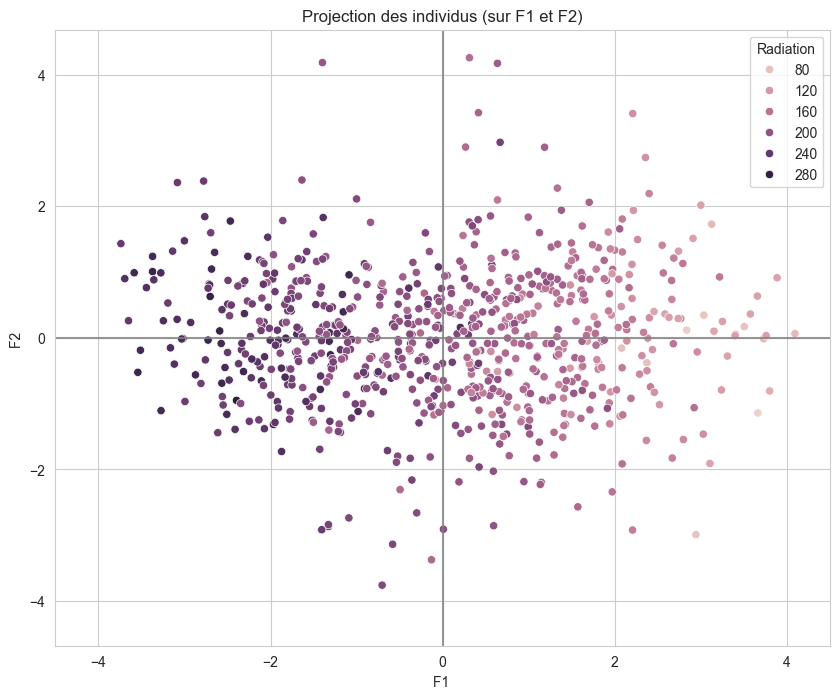

In [147]:
#Me permet de visualiser la projection des individus sur F1 et F2
x_y = [0, 1]
display_factorial_planes(x_proj, x_y, clusters = df.Radiation)

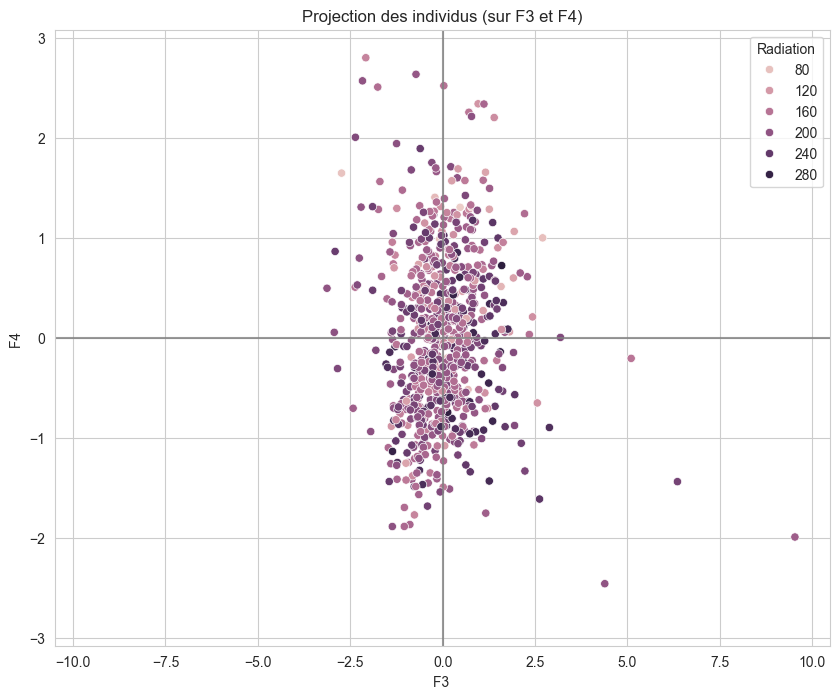

In [148]:
#Me permet de visualiser la projection des individus sur F3 et F4
x_y = [2, 3]
display_factorial_planes(x_proj, x_y, clusters = df.Radiation)

# <font color = '00008f'> <b> VIII- Etude approndie de la Série Temporelle </b> <font/><a class = 'titre4' id = 'titre4'/>

In [150]:
df

Radiation  Temperature  humidity  Pressure  WindDirection  \
datetime                                                                
2023-01-01      208.6         23.8      80.5    1011.8          284.5   
2023-01-02      215.1         24.5      79.1    1011.7          273.5   
2023-01-03      225.9         25.0      76.1    1011.8          276.0   
2023-01-04      199.7         25.2      77.1    1012.0          281.7   
2023-01-05      181.1         24.4      84.8    1012.5          262.7   
...               ...          ...       ...       ...            ...   
2025-02-01      194.1         24.0      72.0    1010.5          261.8   
2025-02-02      221.3         23.9      72.8    1009.7          272.2   
2025-02-03      230.4         23.7      72.5    1009.6          275.4   
2025-02-04      236.9         24.0      72.2    1009.6          273.0   
2025-02-05      227.9         24.7      69.2    1010.1          262.8   

            WindSpeed  
datetime               
2023-01-01       11.5  
2023-01-02       12.2  
2023-01-03       11.2  
2023-01-04       13.0  
2023-01-05       11.5  
...               ...  
2025-02-01        9.7  
2025-02-02       13.3  
2025-02-03       13.7  
2025-02-04       13.3  
2025-02-05        8.6  

[742 rows x 6 columns]

## <font color = 'red'><b>1- Type de série temporelle</b><font/>

In [152]:
series = pd.Series(df.Radiation)
#Décomposition de la série temporelle 
tendance = series.rolling(window = 10).mean()
saisonnalite = series.rolling(window = 10).std()
residus = series - tendance

In [153]:
#Me permet de calculer les bandes 
bande_tendance = tendance.rolling(window = 5).mean()
bande_saisonnalite = saisonnalite.rolling(window = 5).mean()
bande_residus = residus.rolling(window = 5).mean()

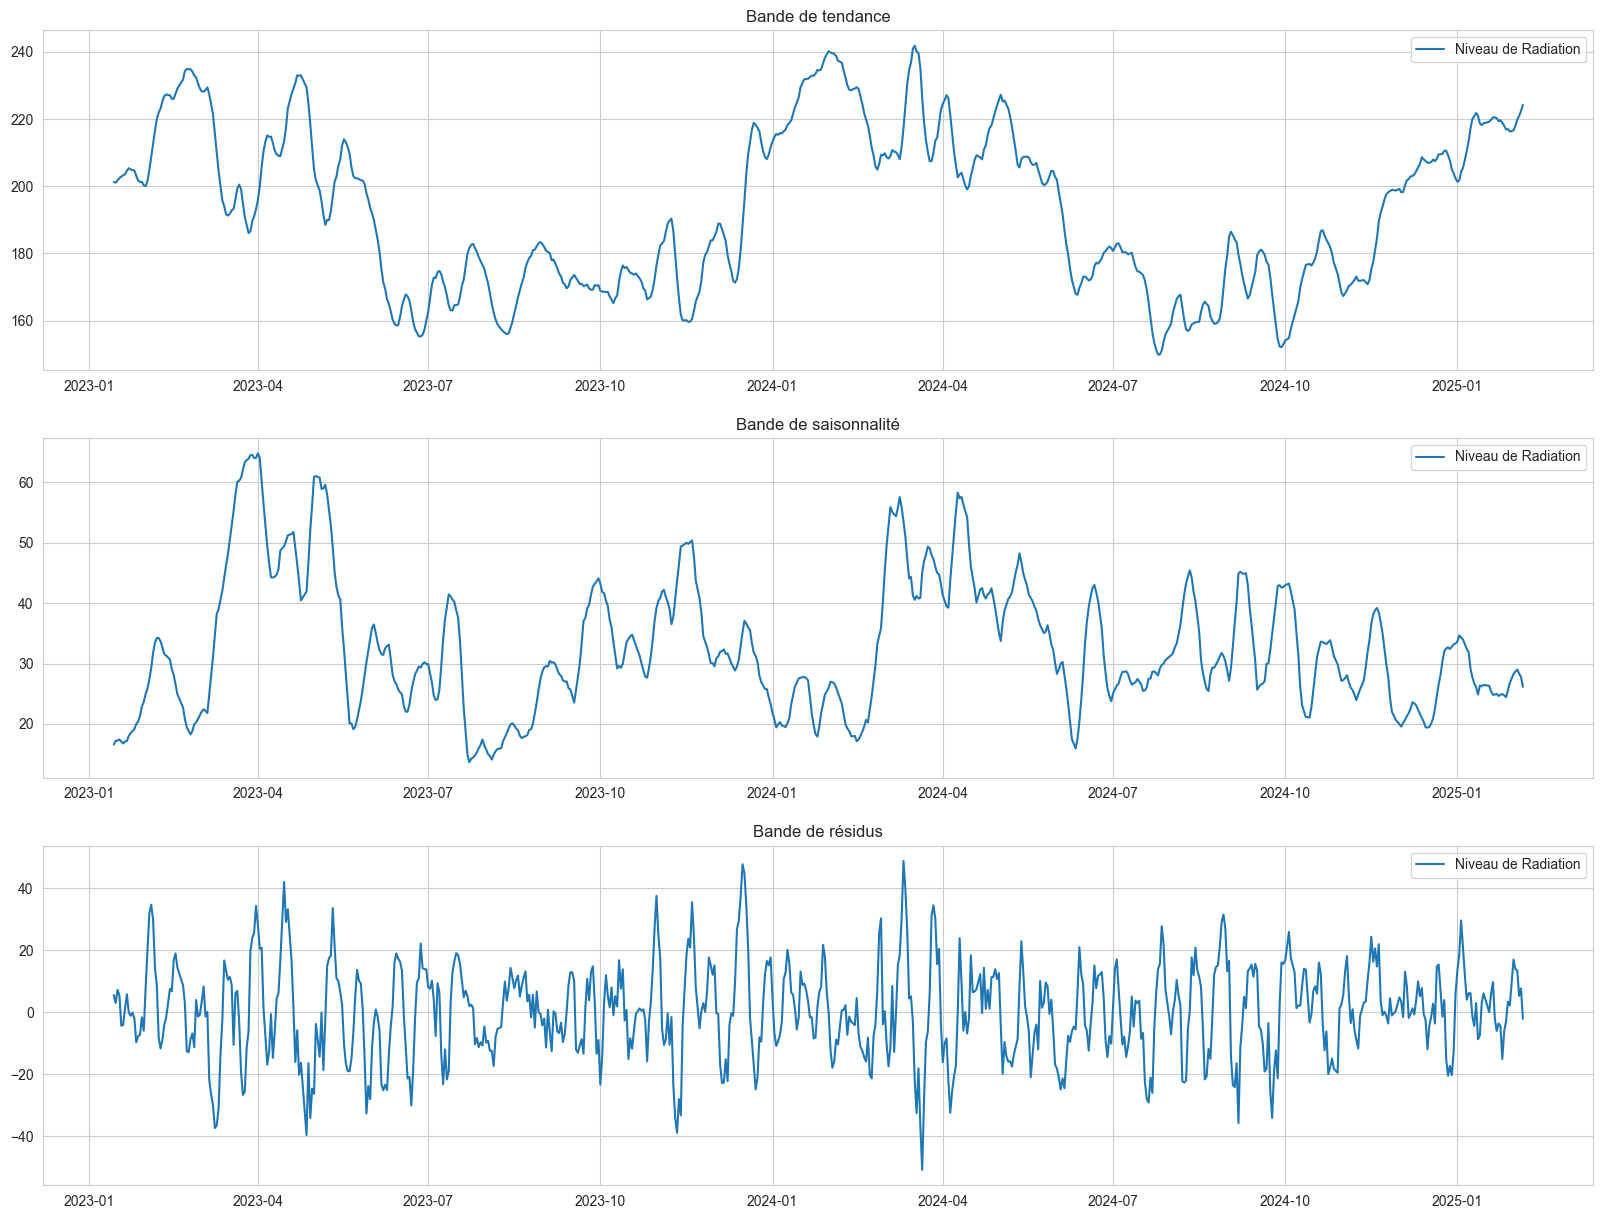

<Figure size 640x480 with 0 Axes>

In [154]:
#Me permet de tracer les résultats donnés 
plt.figure(figsize = (20, 15))
plt.subplot(3, 1, 1)
plt.plot(bande_tendance, label='Niveau de Radiation')
plt.legend()
plt.title('Bande de tendance')
plt.subplot(3, 1, 2)
plt.plot(bande_saisonnalite, label='Niveau de Radiation')
plt.title('Bande de saisonnalité')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(bande_residus, label='Niveau de Radiation')
plt.title('Bande de résidus')
plt.legend()
plt.savefig('Methode_de_la_bande.jpg')
plt.show()
plt.savefig('25.jpg')

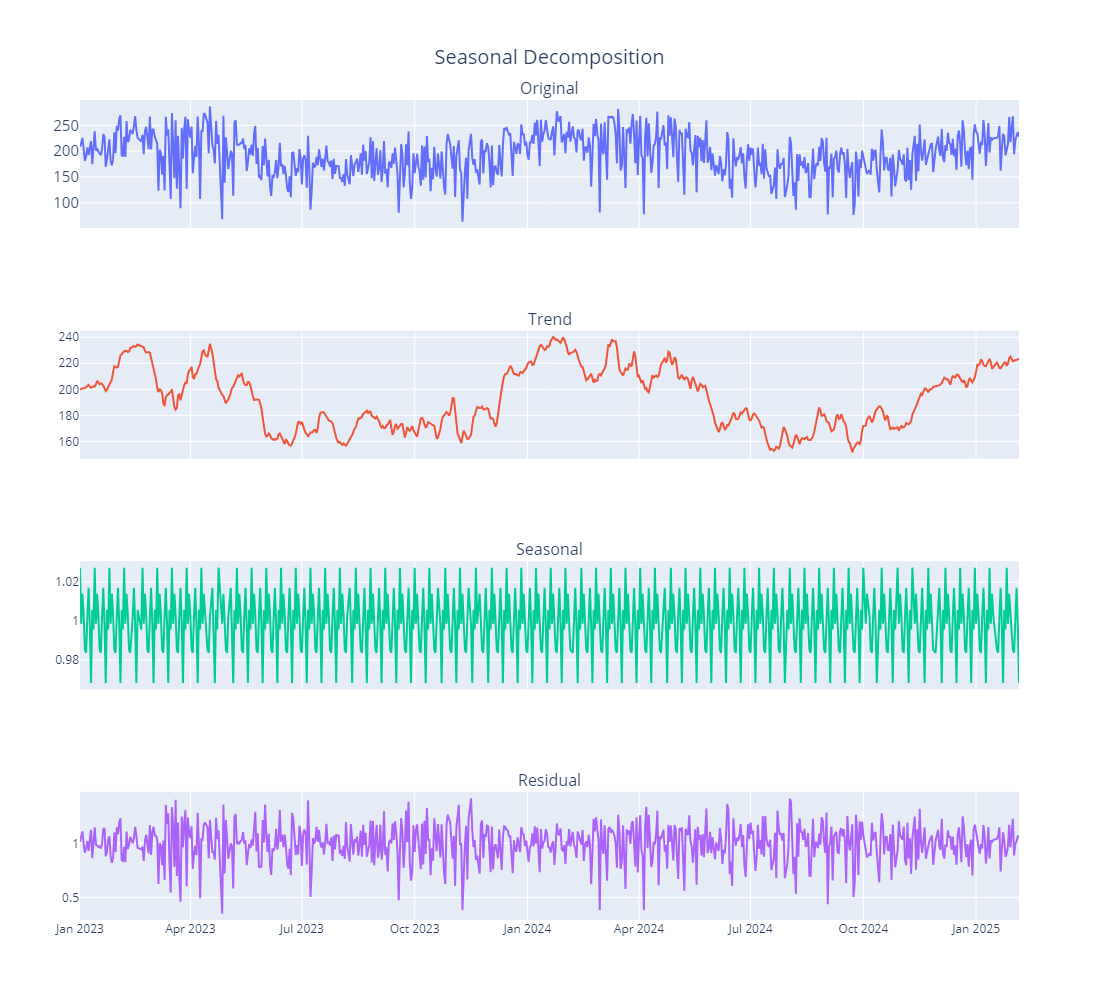

In [155]:
#Par la méthode de moving averages
res = seasonal_decompose(df.Radiation, period=12, model="mul", extrapolate_trend="freq")
fig = decomposition_plot(df.index, res.observed, res.seasonal, res.trend, res.resid)
fig.show()

In [156]:
#Par la méthode de LOESS
stl = STL(seasonality_period=12, model = 'mul')
res_new = stl.fit(df.Radiation)

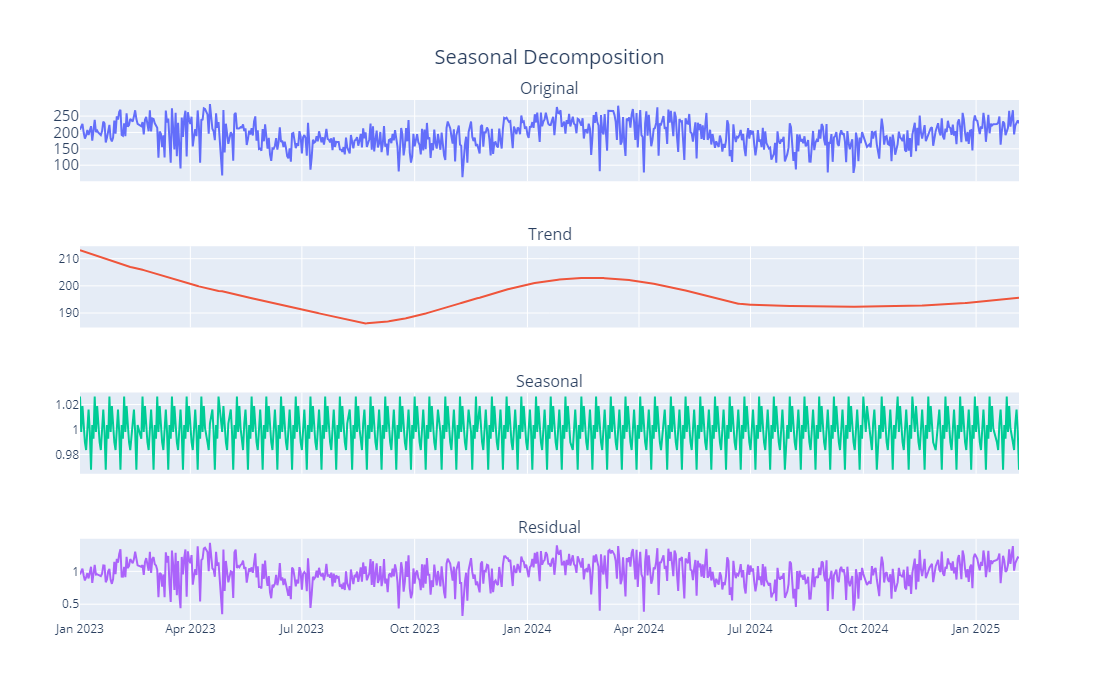

In [157]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.show()

## <font color = 'red'><b>2- Visualisation de l'autocorrélation de la variable cible</b><font/>

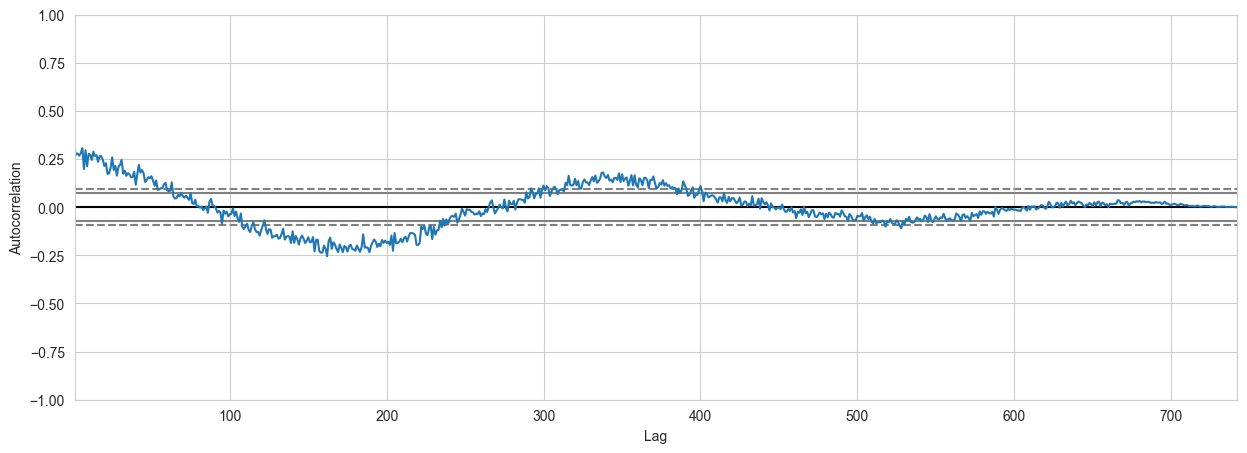

In [159]:
#Me permet de voir l'autocorrélélogramme 
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
pd.plotting.autocorrelation_plot(df.Radiation)
plt.grid()
plt.show()
fig.savefig('28.jpg')

In [160]:
#Me permet de copier les données de la base de données 
xc = df.copy()
#Me permet d'ajouter la colone du week-end
xc['week'] = xc.index.weekday
#Me permet d'ajouter le colonne de la semaine
xc['day'] = xc.index.dayofweek
xc['dayofyear'] = xc.index.dayofyear
xc['year'] = xc.index.year
xc['month']  = xc.index.month
#Me permet d'afficher le résultat
xc

Radiation  Temperature  humidity  Pressure  WindDirection  \
datetime                                                                
2023-01-01      208.6         23.8      80.5    1011.8          284.5   
2023-01-02      215.1         24.5      79.1    1011.7          273.5   
2023-01-03      225.9         25.0      76.1    1011.8          276.0   
2023-01-04      199.7         25.2      77.1    1012.0          281.7   
2023-01-05      181.1         24.4      84.8    1012.5          262.7   
...               ...          ...       ...       ...            ...   
2025-02-01      194.1         24.0      72.0    1010.5          261.8   
2025-02-02      221.3         23.9      72.8    1009.7          272.2   
2025-02-03      230.4         23.7      72.5    1009.6          275.4   
2025-02-04      236.9         24.0      72.2    1009.6          273.0   
2025-02-05      227.9         24.7      69.2    1010.1          262.8   

            WindSpeed  week  day  dayofyear  year  month  
datetime                                                  
2023-01-01       11.5     6    6          1  2023      1  
2023-01-02       12.2     0    0          2  2023      1  
2023-01-03       11.2     1    1          3  2023      1  
2023-01-04       13.0     2    2          4  2023      1  
2023-01-05       11.5     3    3          5  2023      1  
...               ...   ...  ...        ...   ...    ...  
2025-02-01        9.7     5    5         32  2025      2  
2025-02-02       13.3     6    6         33  2025      2  
2025-02-03       13.7     0    0         34  2025      2  
2025-02-04       13.3     1    1         35  2025      2  
2025-02-05        8.6     2    2         36  2025      2  

[742 rows x 11 columns]

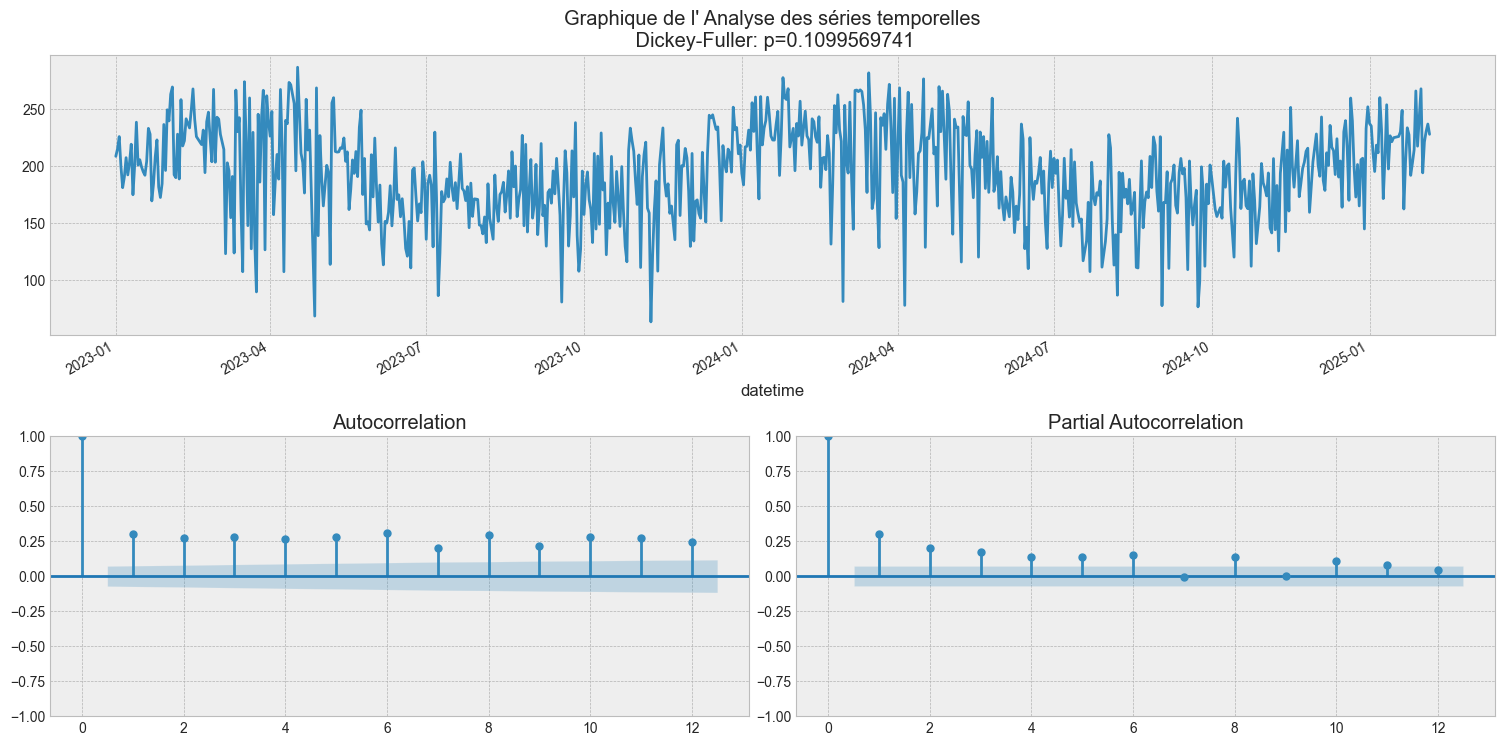

In [161]:
#Me permet de voir l'autocorrélation avec la variable Radiation
tsplot(df.Radiation, lags=12)

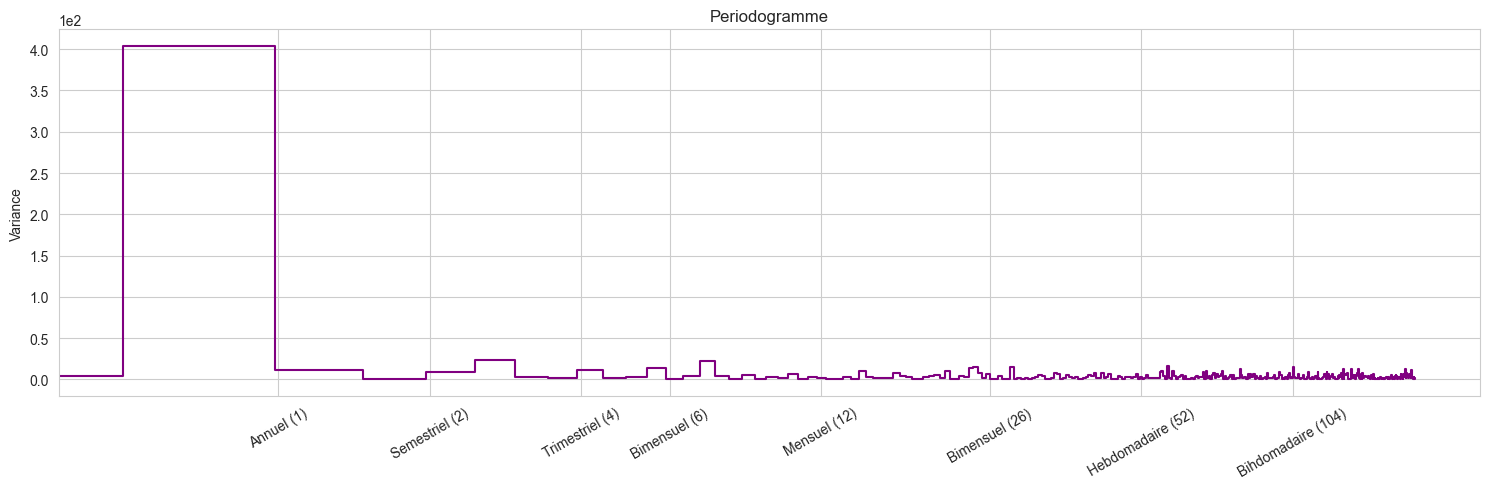

In [162]:
#Me permet de visualiser le periodogramme
plt.rc("figure", autolayout=True, figsize=(15, 5))
plot_periodogram(df.Radiation);

C:\Users\HP\AppData\Local\Temp\ipykernel_15856\3975682222.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




<Axes: title={'center': 'Visualisation Saisonnière (week/dayofyear)'}, xlabel='dayofyear', ylabel='Radiation'>

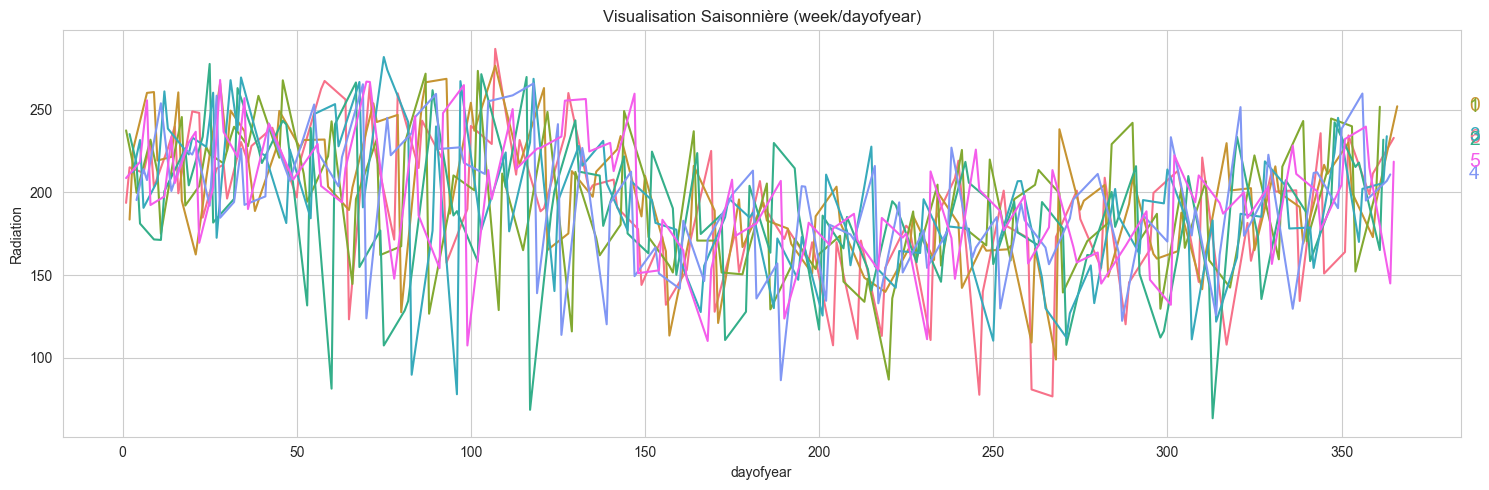

In [163]:
#Me permet de tracer les courbes des graphiques saisonniers
fig, ax0 = plt.subplots(1, 1, figsize=(15, 5))
seasonal_plot(xc, y="Radiation", period="week", freq="dayofyear", ax=ax0)

C:\Users\HP\AppData\Local\Temp\ipykernel_15856\3975682222.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




<Axes: title={'center': 'Visualisation Saisonnière (month/dayofyear)'}, xlabel='dayofyear', ylabel='Radiation'>

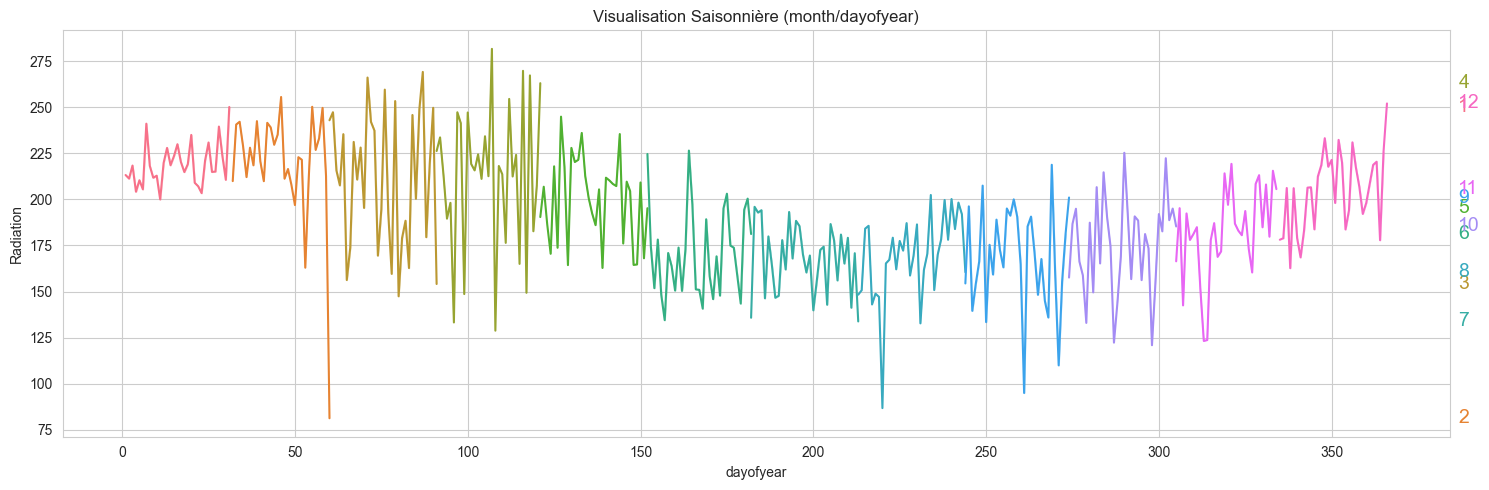

In [164]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
seasonal_plot(xc, y="Radiation", period="month", freq="dayofyear", ax=ax1)

# <font color = '00008f'> <b> IX- Mise en place d'un modèle de référence</b> <font/><a class = 'titre9' id = 'titre9'/>

In [166]:
#Me permet de définir la base de données 
df = df.Radiation

#Me perme de définir le nombre de split 
n_test = 100

#Me permet de définir les configurations du modèle 
max_length = len(df) - n_test
cfg_list = simple_configs(max_length)

#grid search
scores = grid_search(df, cfg_list, n_test)
print('done')

#list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 40.608
 > Model[[2, 1, 'persist']] 40.176
 > Model[[2, 1, 'mean']] 34.902
 > Model[[2, 1, 'median']] 34.902
 > Model[[3, 1, 'persist']] 37.857
 > Model[[3, 1, 'mean']] 31.909
 > Model[[3, 1, 'median']] 33.078
 > Model[[4, 1, 'persist']] 36.673
 > Model[[4, 1, 'mean']] 30.131
 > Model[[4, 1, 'median']] 30.525
 > Model[[5, 1, 'persist']] 38.718
 > Model[[5, 1, 'mean']] 29.655
 > Model[[5, 1, 'median']] 29.252
 > Model[[6, 1, 'persist']] 40.070
 > Model[[6, 1, 'mean']] 29.585
 > Model[[6, 1, 'median']] 30.034
 > Model[[7, 1, 'persist']] 41.117
 > Model[[7, 1, 'mean']] 29.701
 > Model[[7, 1, 'median']] 30.634
 > Model[[8, 1, 'persist']] 40.538
 > Model[[8, 1, 'mean']] 29.571
 > Model[[8, 1, 'median']] 29.861
 > Model[[9, 1, 'persist']] 39.646
 > Model[[9, 1, 'mean']] 29.322
 > Model[[9, 1, 'median']] 29.679
 > Model[[10, 1, 'persist']] 36.926
 > Model[[10, 1, 'mean']] 28.774
 > Model[[10, 1, 'median']] 29.079
 > Model[[11, 1, 'persist']] 39.945
 > Model[[11, 1, 